In [1]:
import ete3
import pandas as pd
import re
import multiprocessing
import numpy as np
import itertools
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn import manifold
import networkx as nx
import community
import random
import collections
import operator

%cd /work/kelsey/hgt/

/work/kelsey/hgt


In [2]:
def get_node_age_from_descendants(tree, descendants):
    node = tree.get_common_ancestor(descendants)
    return(node.support)

In [3]:
tree              = ete3.Tree('species_tree')
ranger_named_tree = ete3.Tree('species_tree_named_nodes', format=1)

genomes           = pd.read_csv('../genomes.tab', sep='\t', index_col=0)
genomes.Organism  = genomes.Organism.replace('\s+\(.+\)$', '', regex=True)

transfer_df       = pd.read_csv('transfers-filtered_by_confidence.tab', sep='\t', index_col=0)

name_conversion = {}
for index, row in genomes.iterrows():
    if index.startswith('GC'):
        name_conversion[row.abbreviation] = re.sub('\.\d+$', '', index, flags=re.M).replace('_', '')
    else:
        name_conversion[row.abbreviation] = row.accession.replace('_', '')

for leaf in tree.get_leaves():
    if leaf.name in name_conversion:
        leaf.add_feature('accession', name_conversion[leaf.name])
    else:
        leaf.add_feature('accession', leaf.name.replace('_', ''))

In [4]:
name_table = pd.DataFrame(columns=['name', 'accession'],
                          data=[(leaf.name, leaf.accession) for leaf in tree.get_leaves()])

for node in ranger_named_tree.traverse():
    if node.is_leaf():
        continue

    descendants     = name_table.loc[name_table.accession.isin(node.get_leaf_names()),
                                     'name'].values.tolist()
    equivalent      = tree.get_common_ancestor(descendants)
    equivalent.name = node.name

In [5]:
posterior_trees = [ete3.Tree(line)
                   for line in open('Cyano_modelBB_long_ugam_bd_7_20_sample.datedist').readlines()]

In [6]:
constraints = list(
    transfer_df.groupby(['donor', 'recipient']).groups.keys()
)

In [7]:
def assess_constraint_compatibility(constraint):
    older_bound   = next(tree.iter_search_nodes(name=constraint[0]))
    younger_bound = next(tree.iter_search_nodes(name=constraint[1]))
    
    compatibilities = []
    for tmp_tree in posterior_trees:
        older_bound_age   = get_node_age_from_descendants(tmp_tree,   older_bound.get_leaf_names())
        younger_bound_age = get_node_age_from_descendants(tmp_tree, younger_bound.get_leaf_names())
        
        if older_bound_age > younger_bound_age:
            compatibilities.append(True)
        else:
            compatibilities.append(False)

    return(compatibilities)

In [8]:
pool    = multiprocessing.Pool(processes=20)
results = pool.map(assess_constraint_compatibility, constraints)

compatibility_table = pd.DataFrame(columns=constraints,
                                   data   =np.array(results).T)

compatibility_count      = compatibility_table.sum()
compatibility_count.name = 'compatibility_count'

In [185]:
def assess_constraint_compatibility2(constraint):
    younger_bound = next(tree.iter_search_nodes(name=constraint[0]))
    older_bound   = next(younger_bound.iter_ancestors())
    recipient     = next(tree.iter_search_nodes(name=constraint[1]))
    
    compatibilities = []
    for tmp_tree in posterior_trees:
        older_bound_age   = get_node_age_from_descendants(tmp_tree,   older_bound.get_leaf_names())
        younger_bound_age = get_node_age_from_descendants(tmp_tree, younger_bound.get_leaf_names())
        recipient_age     = get_node_age_from_descendants(tmp_tree,     recipient.get_leaf_names())
        
        if older_bound_age > recipient_age > younger_bound_age:
            compatibilities.append(True)
        else:
            compatibilities.append(False)

    return(compatibilities)

In [186]:
pool    = multiprocessing.Pool(processes=20)
results = pool.map(assess_constraint_compatibility2, constraints)

compatibility_table2 = pd.DataFrame(columns=constraints,
                                    data   =np.array(results).T)

compatibility_count2      = compatibility_table.sum()
compatibility_count2.name = 'compatibility_count'

In [9]:
def jaccard_between_constraints(constraints):
    intersection = sum(compatibility_table[constraints].T.all())
    union        = sum(compatibility_table[constraints].T.any())
    
    if not union:
        return(0.0)
    else:
        return(intersection/union)

In [10]:
pairs_of_constraints = [list(pair) for pair in itertools.combinations(constraints, 2)]

In [11]:
pool                = multiprocessing.Pool(processes=20)
condensed_distances = np.array(
    pool.map(jaccard_between_constraints, pairs_of_constraints)
)

jaccard_distances = pd.DataFrame(index=constraints,
                                 columns=constraints,
                                 data=squareform(condensed_distances))

Process ForkPoolWorker-22:
Process ForkPoolWorker-29:
Process ForkPoolWorker-28:
Process ForkPoolWorker-37:
Process ForkPoolWorker-23:
Process ForkPoolWorker-24:
Process ForkPoolWorker-39:
Process ForkPoolWorker-31:
Process ForkPoolWorker-38:
Process ForkPoolWorker-25:
Process ForkPoolWorker-33:
Process ForkPoolWorker-27:
Process ForkPoolWorker-30:
Process ForkPoolWorker-21:
Process ForkPoolWorker-32:
Process ForkPoolWorker-26:
Process ForkPoolWorker-35:
Process ForkPoolWorker-36:
Process ForkPoolWorker-40:
Process ForkPoolWorker-34:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Trace

  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/Users/thiberio/

In [187]:
def jaccard_between_constraints2(constraints):
    intersection = sum(compatibility_table2[constraints].T.all())
    union        = sum(compatibility_table2[constraints].T.any())
    
    if not union:
        return(0.0)
    else:
        return(intersection/union)

In [188]:
pool                = multiprocessing.Pool(processes=20)
condensed_distances2 = np.array(
    pool.map(jaccard_between_constraints2, pairs_of_constraints)
)

jaccard_distances2 = pd.DataFrame(index=constraints,
                                 columns=constraints,
                                 data=squareform(condensed_distances2))

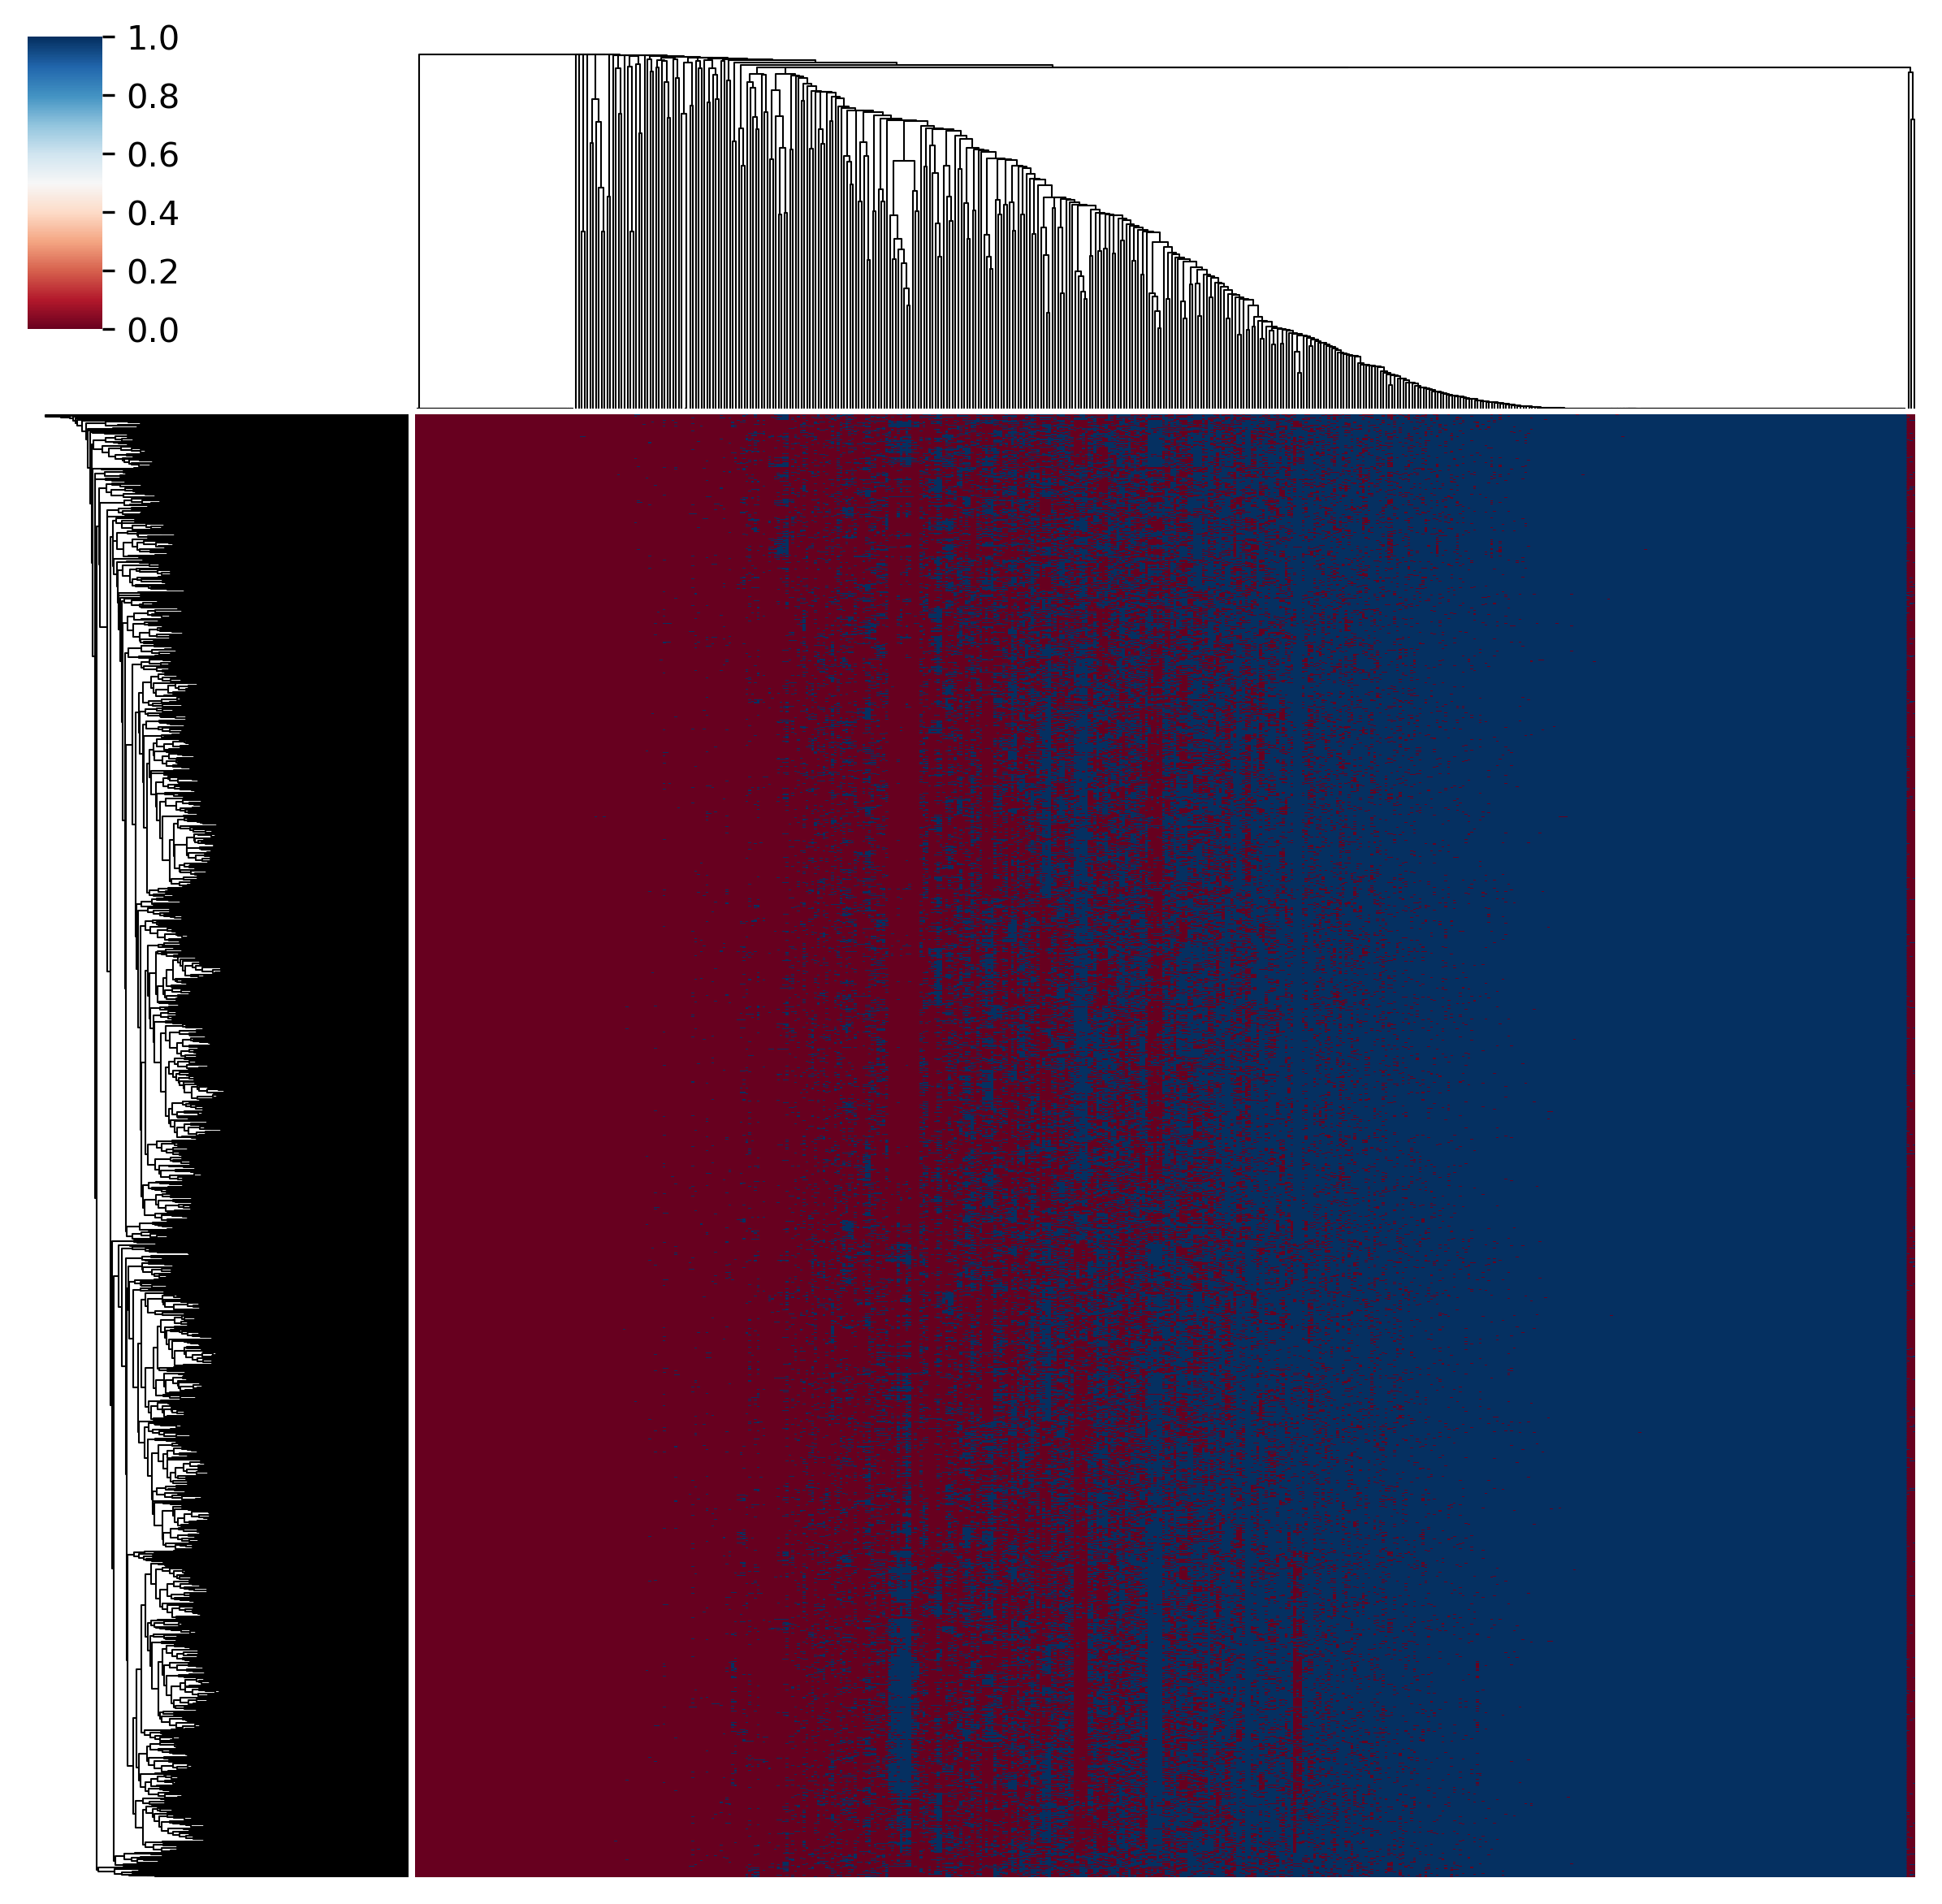

In [12]:
linkage_col = hierarchy.linkage(compatibility_table.T, method='average', metric='jaccard')
linkage_row = hierarchy.linkage(compatibility_table,   method='average', metric='jaccard')

clst_map = sns.clustermap(compatibility_table,
                          row_linkage=linkage_row,
                          col_linkage=linkage_col,
                          cmap='RdBu',
                          yticklabels=False,
                          xticklabels=False);
clst_map.fig.set_dpi(300)
#clst_map.fig.set_size_inches(10, 20)

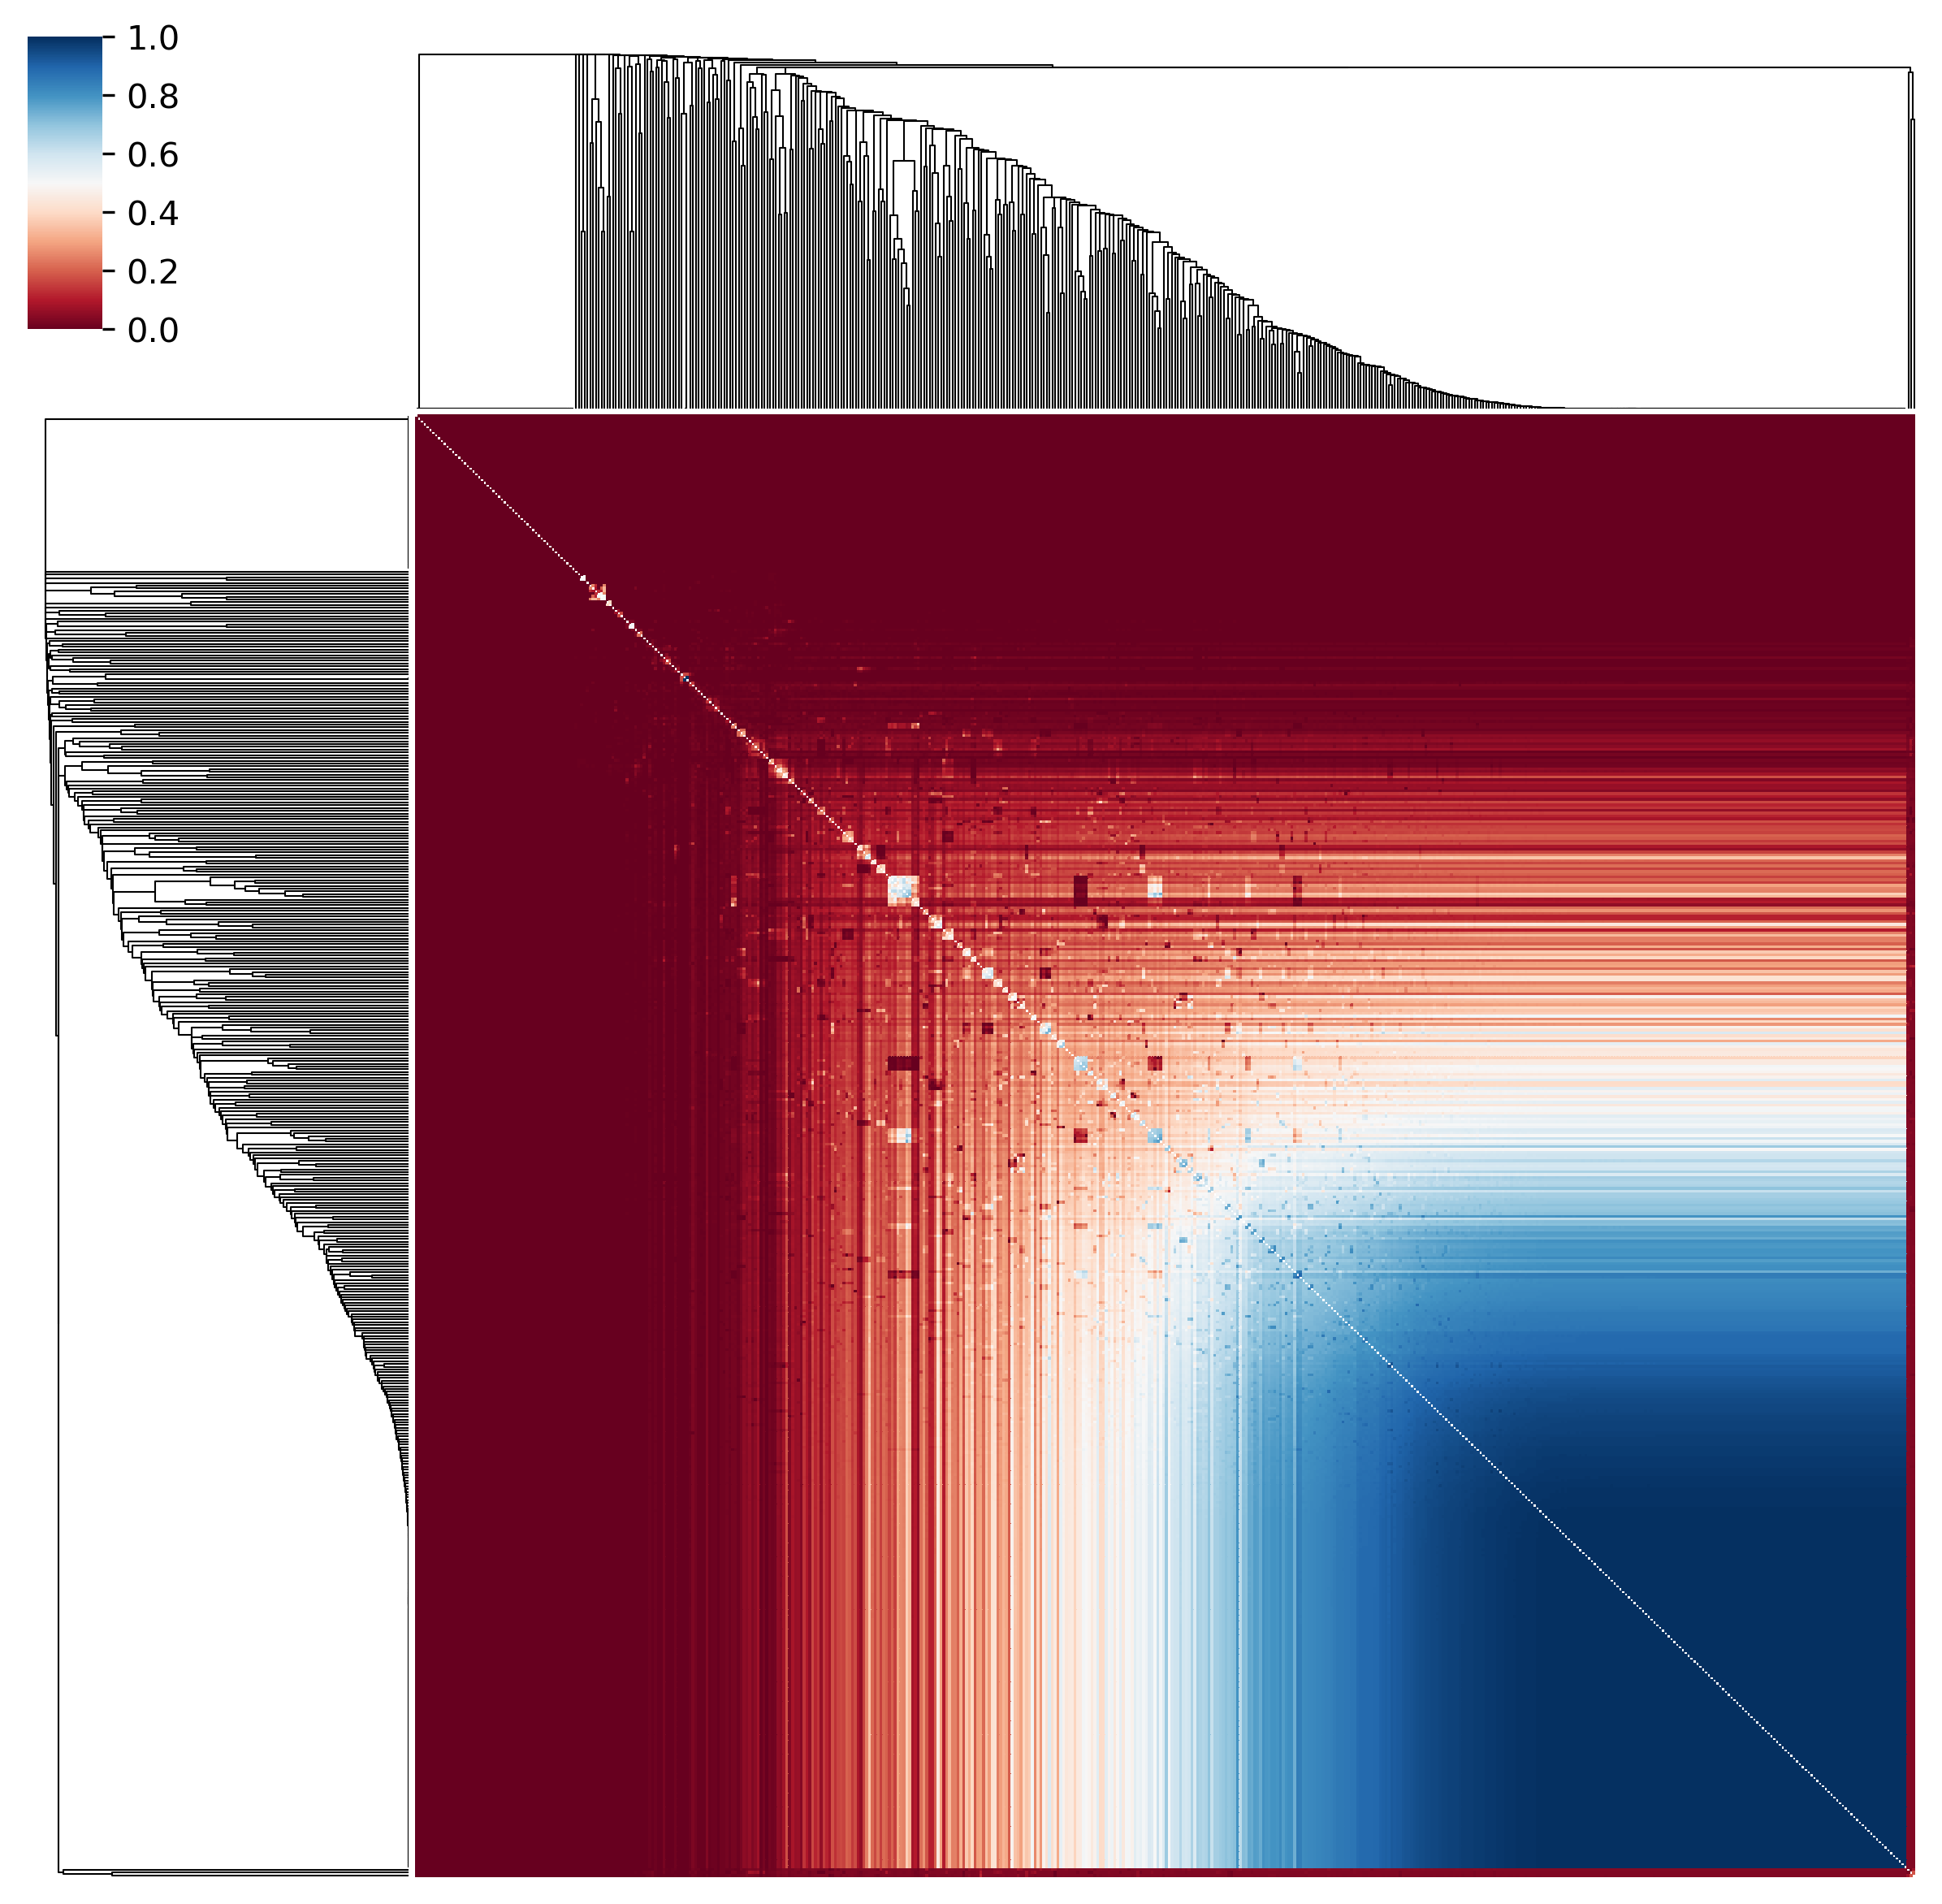

In [13]:
#linkage = hierarchy.linkage(1-condensed_distances, method='average', metric='precomputed')

tmp_df = jaccard_distances.copy()
np.fill_diagonal(tmp_df.values, np.nan)

clst_map = sns.clustermap(tmp_df,
                          row_linkage=linkage_col,
                          col_linkage=linkage_col,
                          cmap='RdBu',
                          yticklabels=False,
                          xticklabels=False);
clst_map.fig.set_dpi(300)

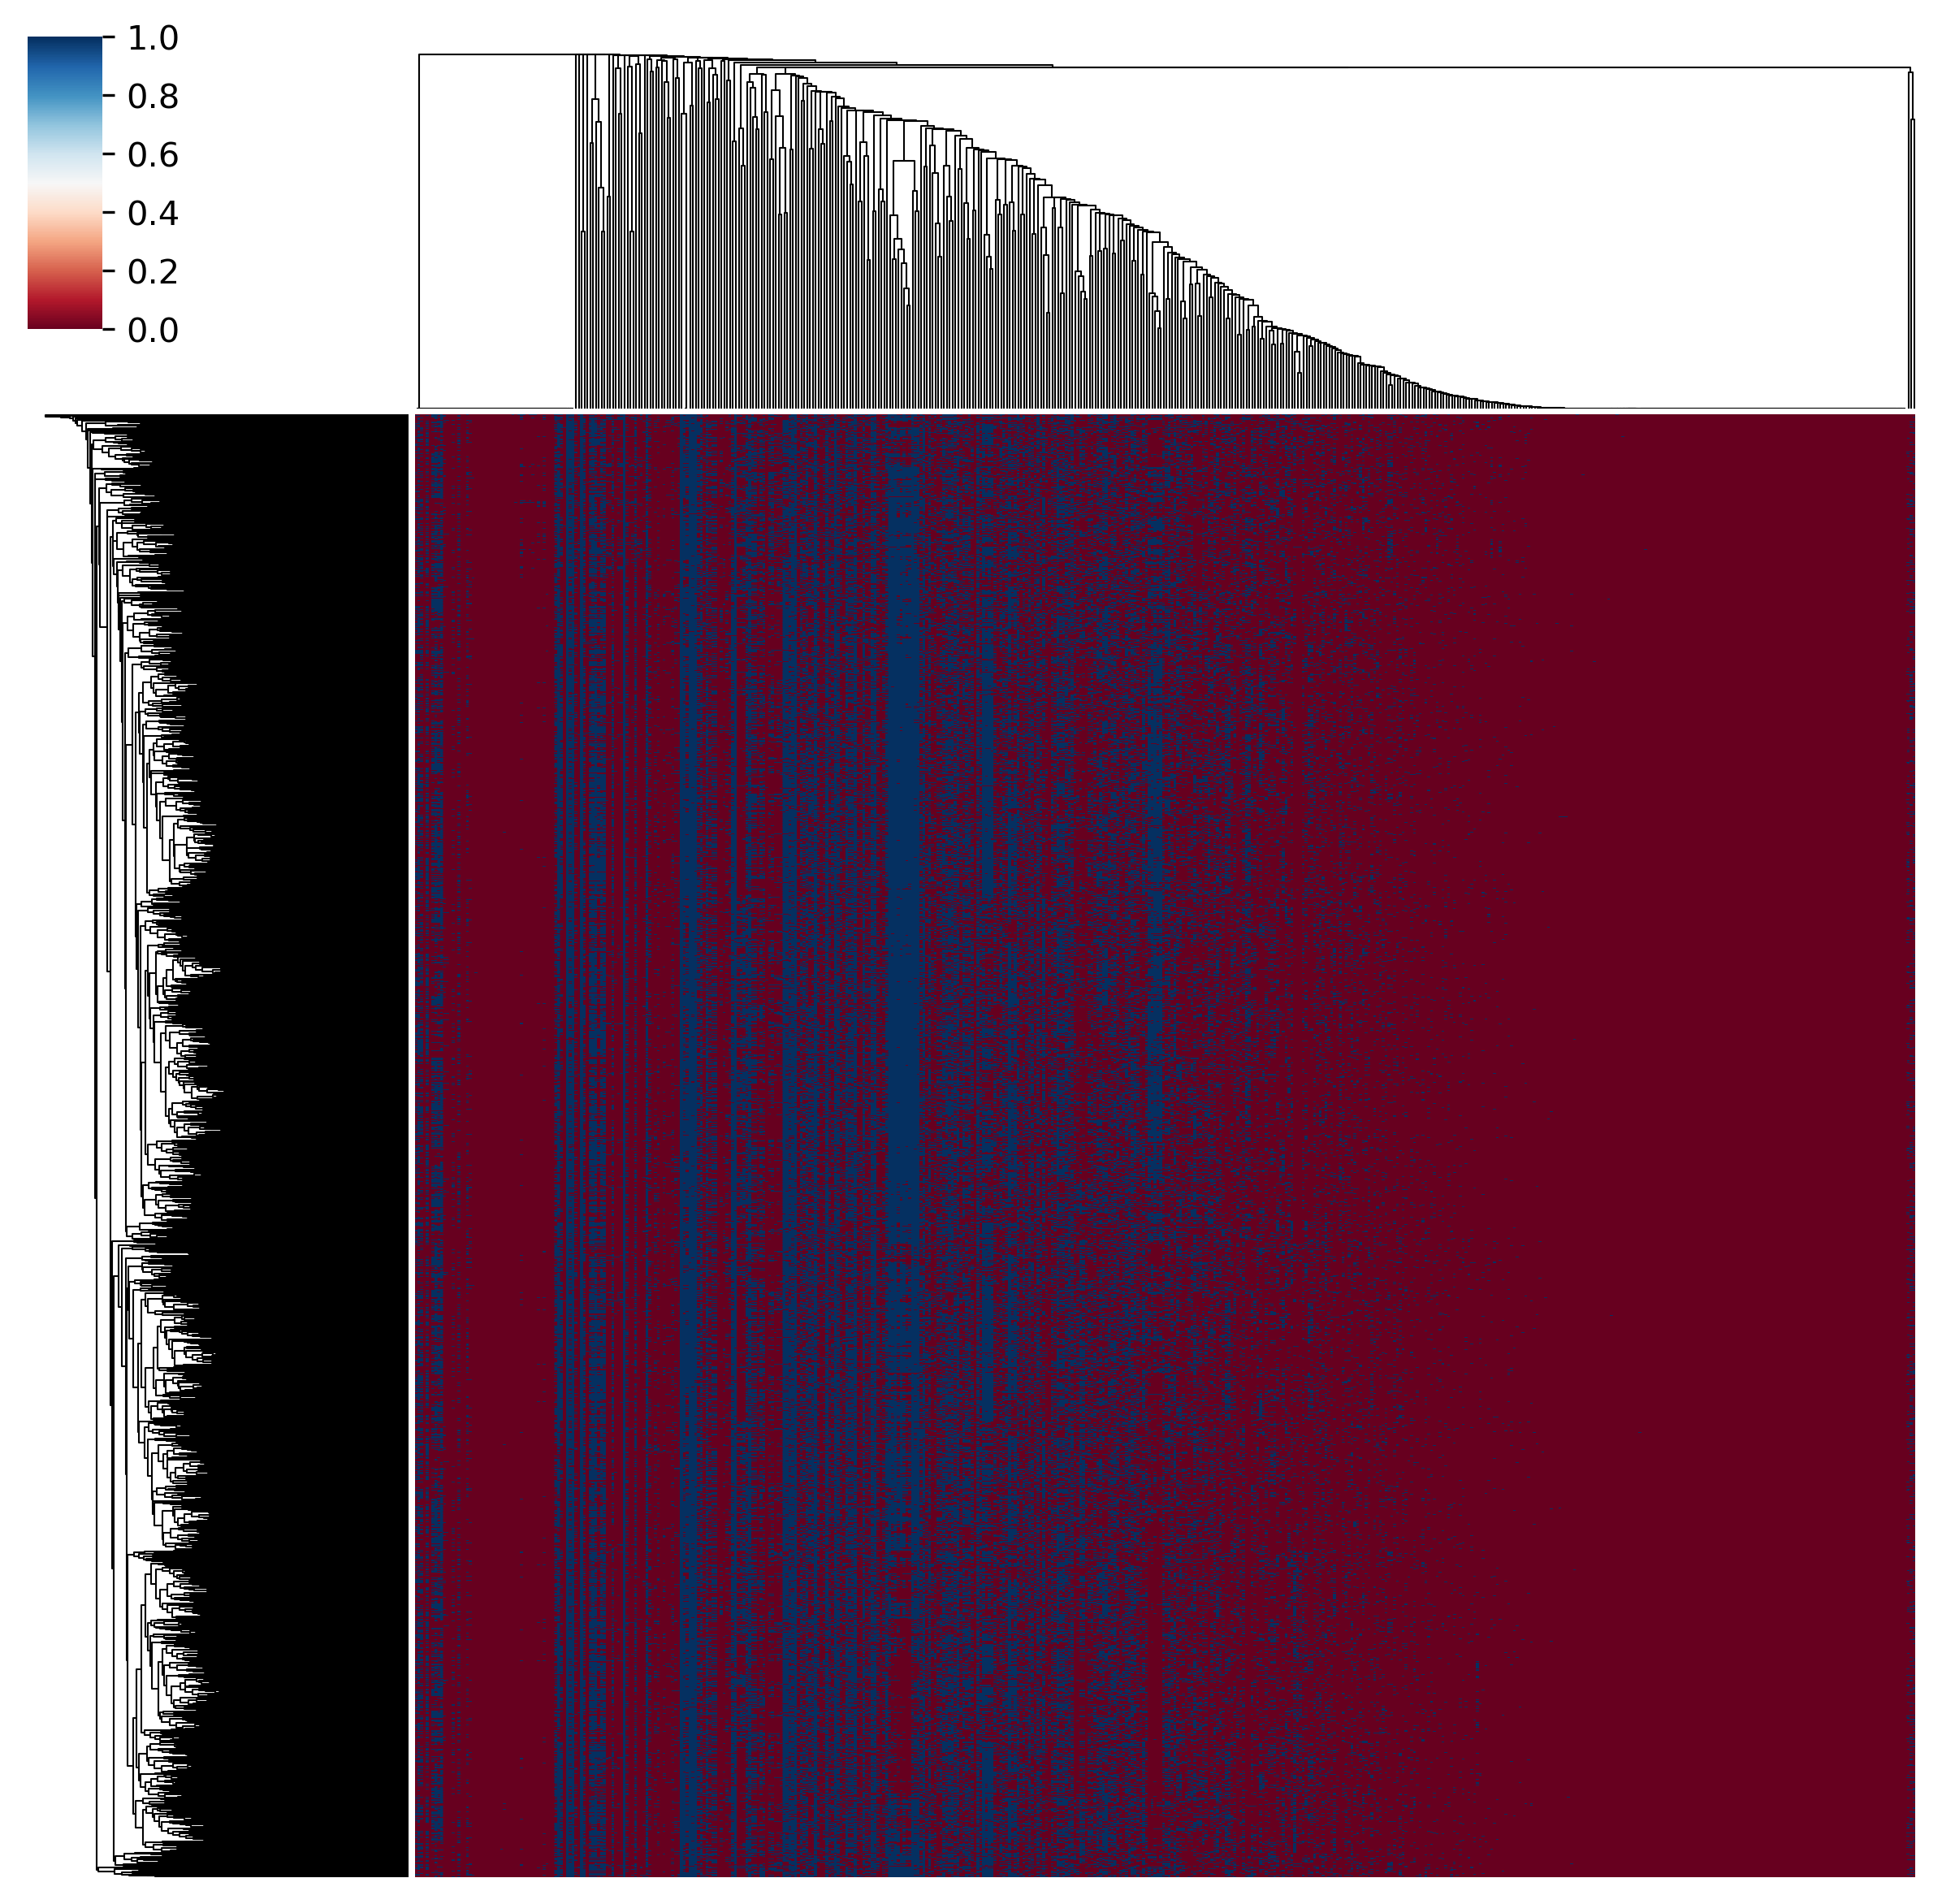

In [189]:
linkage_col2 = hierarchy.linkage(compatibility_table2.T, method='average', metric='jaccard')
linkage_row2 = hierarchy.linkage(compatibility_table2,   method='average', metric='jaccard')

clst_map = sns.clustermap(compatibility_table2,
                          row_linkage=linkage_row,
                          col_linkage=linkage_col,
                          cmap='RdBu',
                          yticklabels=False,
                          xticklabels=False);
clst_map.fig.set_dpi(300)
#clst_map.fig.set_size_inches(10, 20)

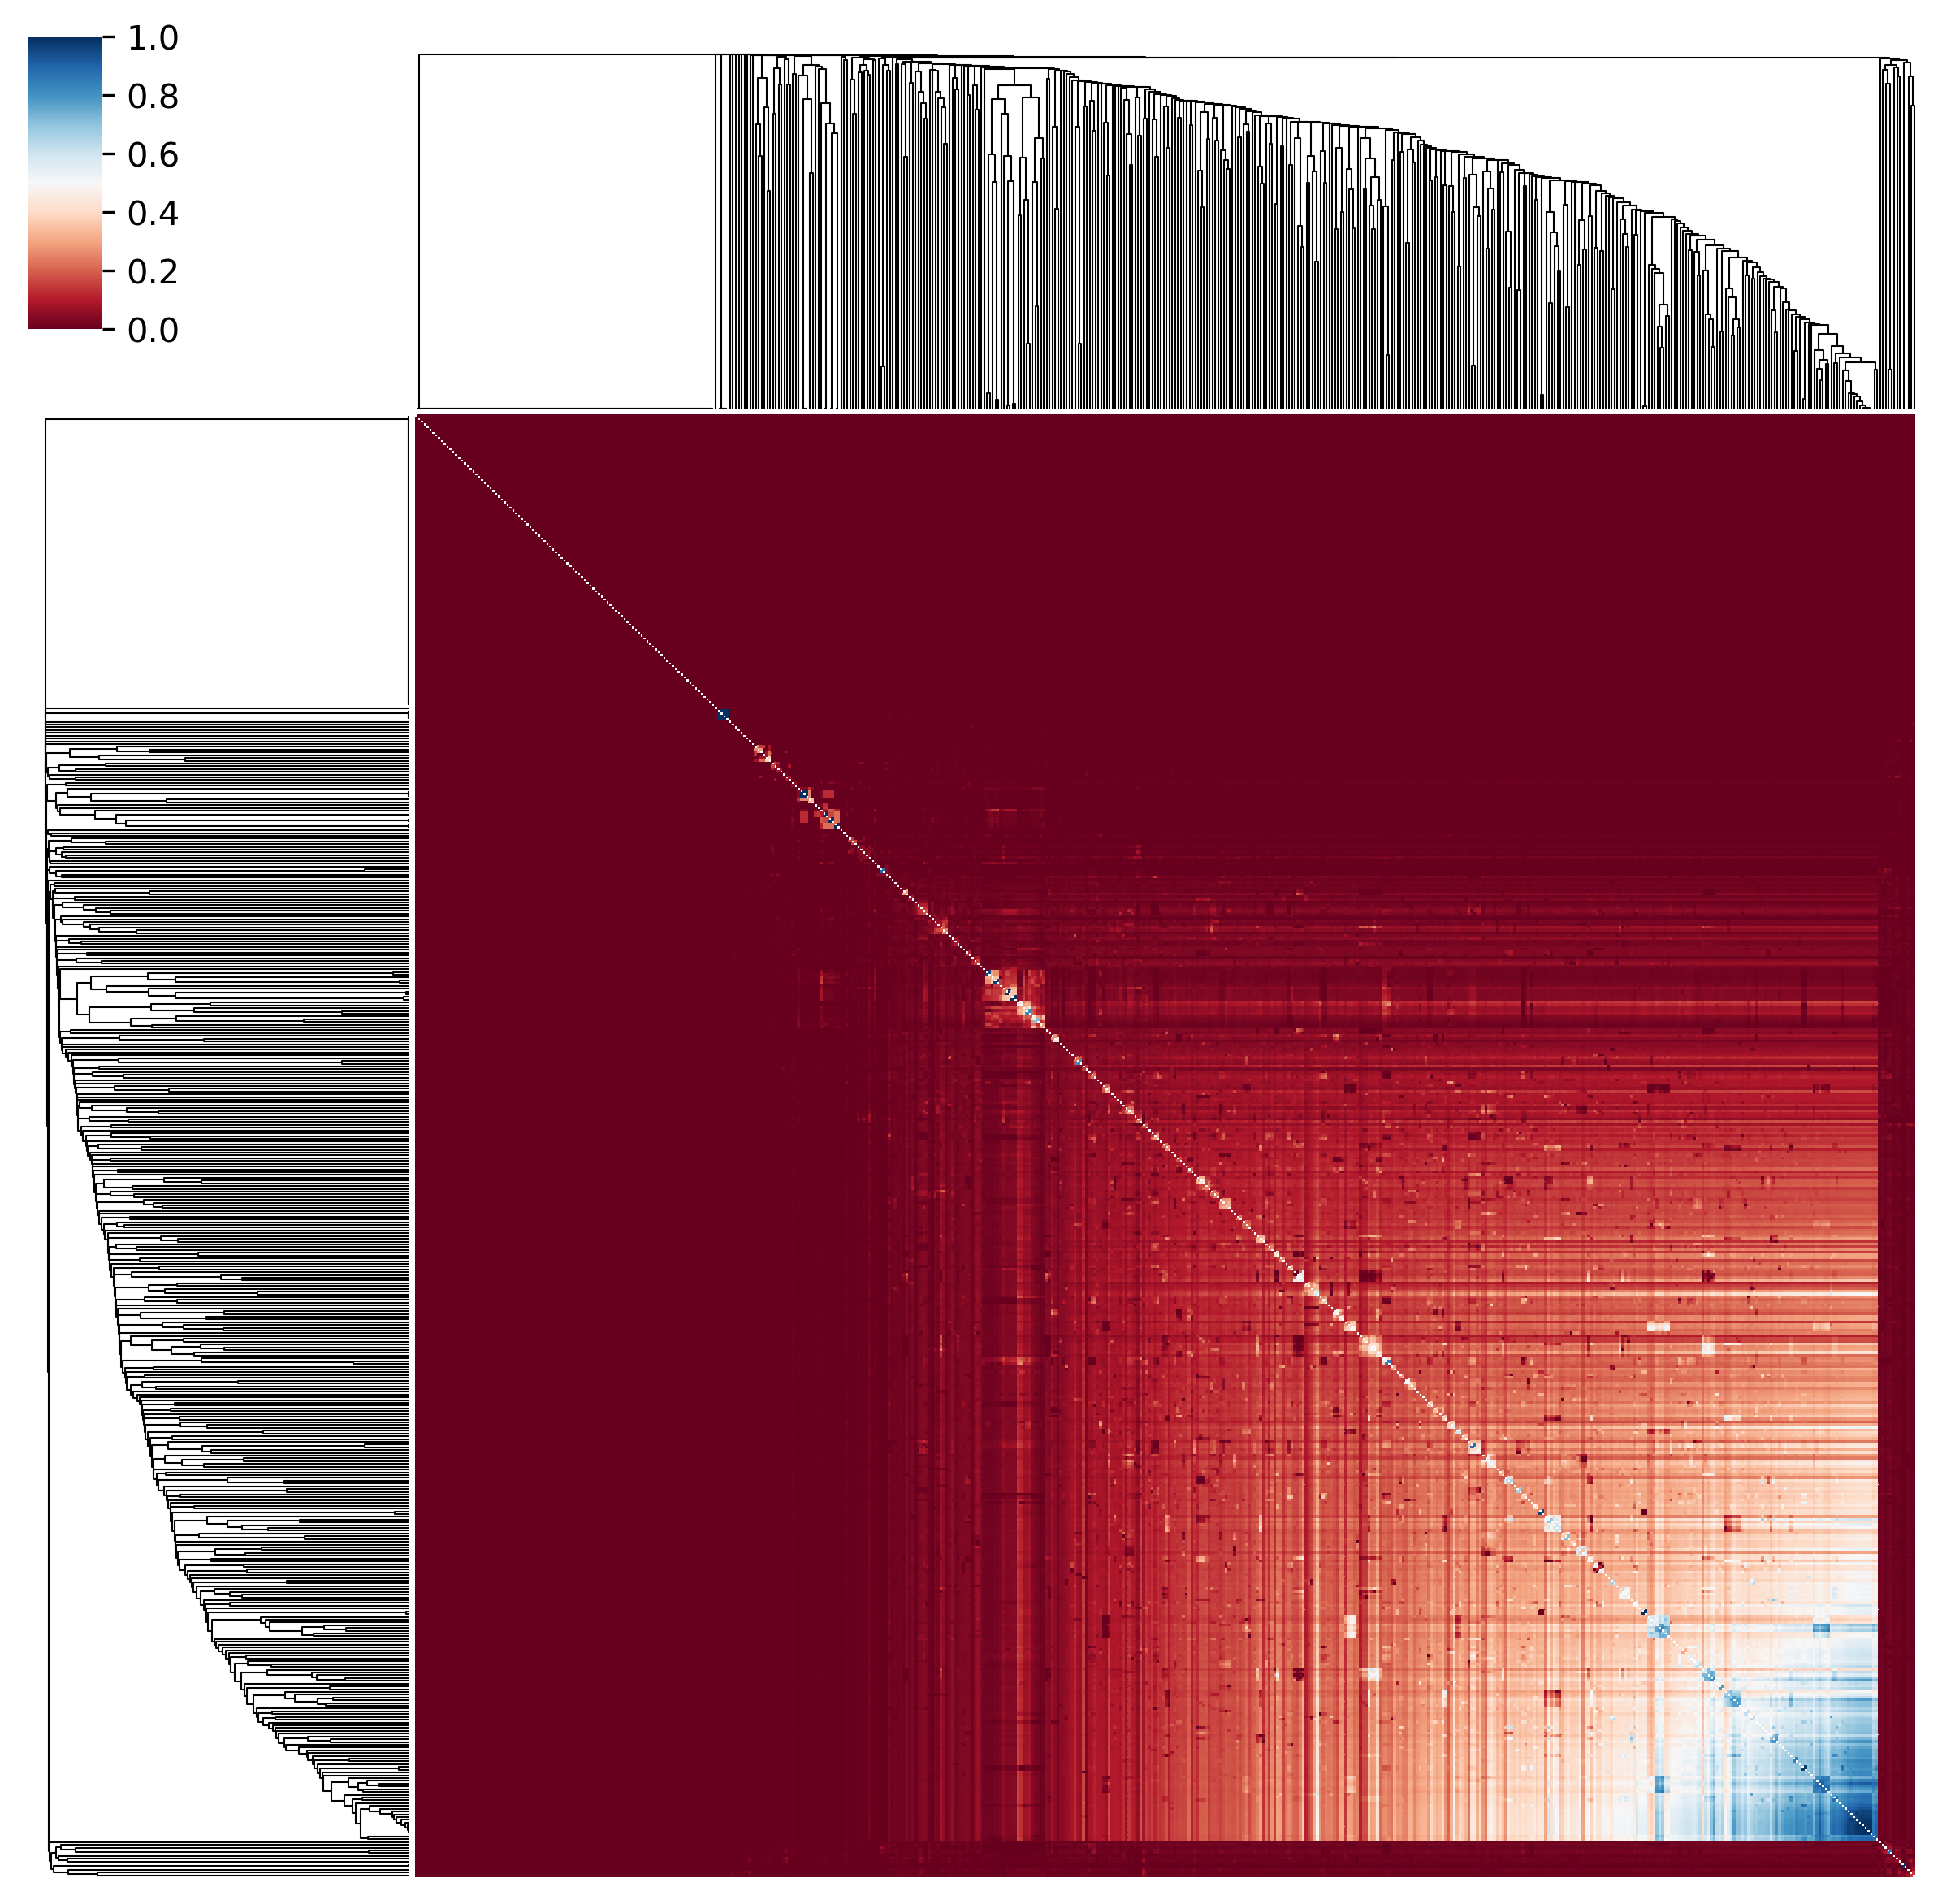

In [191]:
#linkage = hierarchy.linkage(1-condensed_distances, method='average', metric='precomputed')

tmp_df2 = jaccard_distances2.copy()
np.fill_diagonal(tmp_df2.values, np.nan)

clst_map = sns.clustermap(tmp_df2,
                          row_linkage=linkage_col2,
                          col_linkage=linkage_col2,
                          cmap='RdBu',
                          yticklabels=False,
                          xticklabels=False);
clst_map.fig.set_dpi(300)

In [192]:
tmp_df = 1-jaccard_distances2
np.fill_diagonal(tmp_df.values, 0)

mds = manifold.MDS(n_components=2,
                   dissimilarity='precomputed',
                   random_state=12345)
mds_result = mds.fit(tmp_df)

coords     = mds_result.embedding_
constraintX, constraintY = coords[:, 0], coords[:, 1]

In [193]:
tmp_df         = jaccard_distances2.copy()
tmp_df.index   = range(jaccard_distances.shape[0])
tmp_df.columns = range(jaccard_distances.shape[0])

In [195]:
graph   = nx.convert_matrix.from_pandas_adjacency(tmp_df)
louvain = community.best_partition(graph, random_state=12345)

In [196]:
clusters = []
for count, constraint in enumerate(constraints):
    clusters.append(louvain[count])

cluster_frequencies     = dict(collections.Counter(clusters))
clusters_sorted_by_size = sorted(cluster_frequencies.items(), key=operator.itemgetter(1), reverse=True)

In [198]:
cluster_coords                 = pd.DataFrame(columns='x y cluster'.split(), 
                                              data=zip(constraintX,constraintY, clusters))
cluster_coords['cluster_size'] = [cluster_frequencies[cluster]
                                  for cluster in cluster_coords.cluster]
cluster_coords.loc[cluster_coords.cluster_size<3, 'cluster'] = 'none'

cluster_coords.index = constraints
cluster_coords       = cluster_coords.join(compatibility_count2)

constraint_supports = {constraint:len(indexes)
                       for constraint, indexes in transfer_df.groupby(['donor', 'recipient']).groups.items()}
cluster_coords      = cluster_coords.join(
    pd.DataFrame.from_dict([constraint_supports]).T
)
cluster_coords.rename(columns={0:'constraint_support'}, inplace=True)

constraint_distance = [tree.get_distance(node1, node2)
                      for node1, node2 in cluster_coords.index]
cluster_coords['constraint_distance'] = constraint_distance

In [199]:
constrained_families = []
for donor, recipient in cluster_coords.index:
    tmp = transfer_df.loc[(transfer_df.donor==donor) &
                          (transfer_df.recipient==recipient),
                          'family']
    constrained_families.append(';'.join(tmp.values))
cluster_coords['constrained_families'] = constrained_families

In [44]:
cluster_coords.to_csv('constraint_clusters-BB.tab', sep='\t')

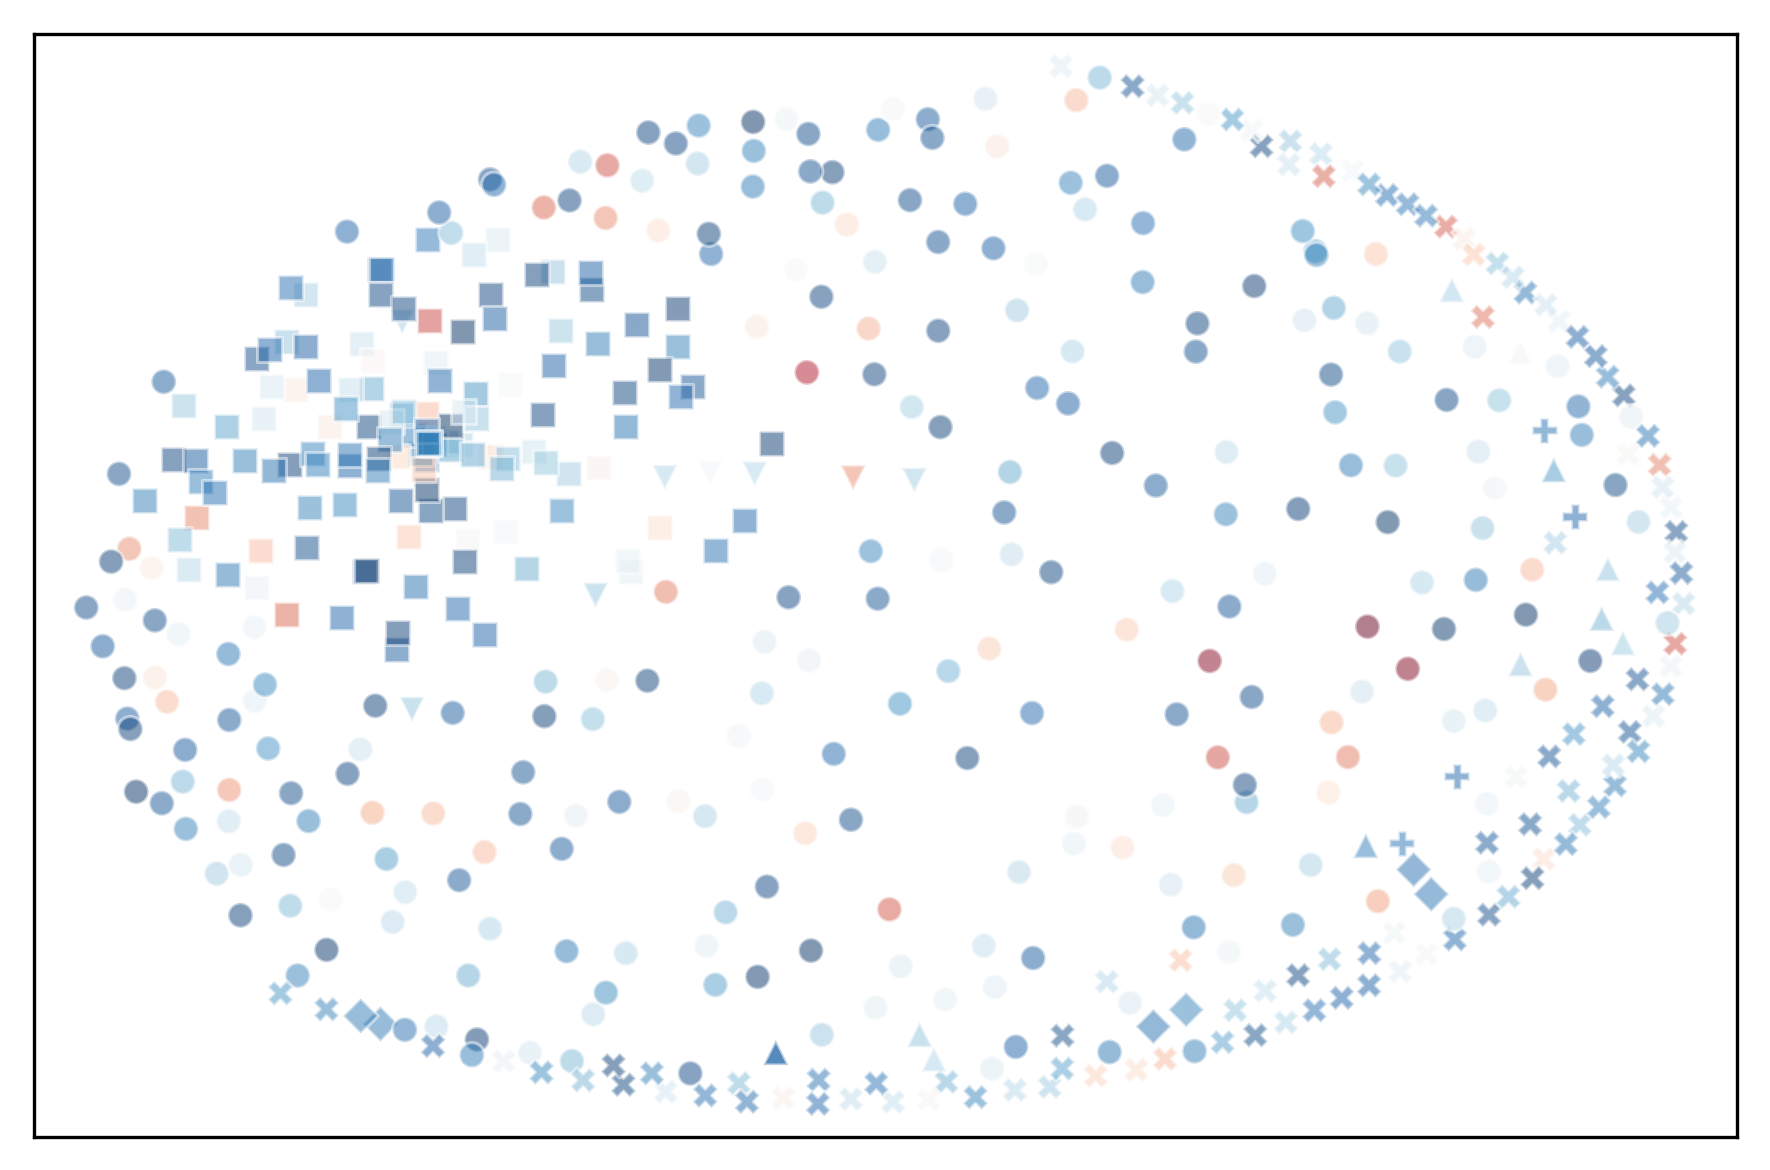

In [200]:
fig, ax = plt.subplots()

yeah = sns.scatterplot(x='x', 
                y='y',
                style='cluster',
                hue='constraint_distance',
                palette='RdBu_r',
                data=cluster_coords,
                alpha=0.5,
#                size='compatibility_count',
#                color='black',
                legend=False,
                ax=ax,
                      cmap=plt.cm.get_cmap('cubehelix', 6));

ax.tick_params(axis='both',
               which='both',
               bottom=False,
               labelbottom=False,
               left=False,
               labelleft=False)

#ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(constraintX.min()-0.05, constraintX.max()+0.05)
ax.set_ylim(constraintY.min()-0.05, constraintY.max()+0.05)
fig.set_dpi(300)
fig.tight_layout()

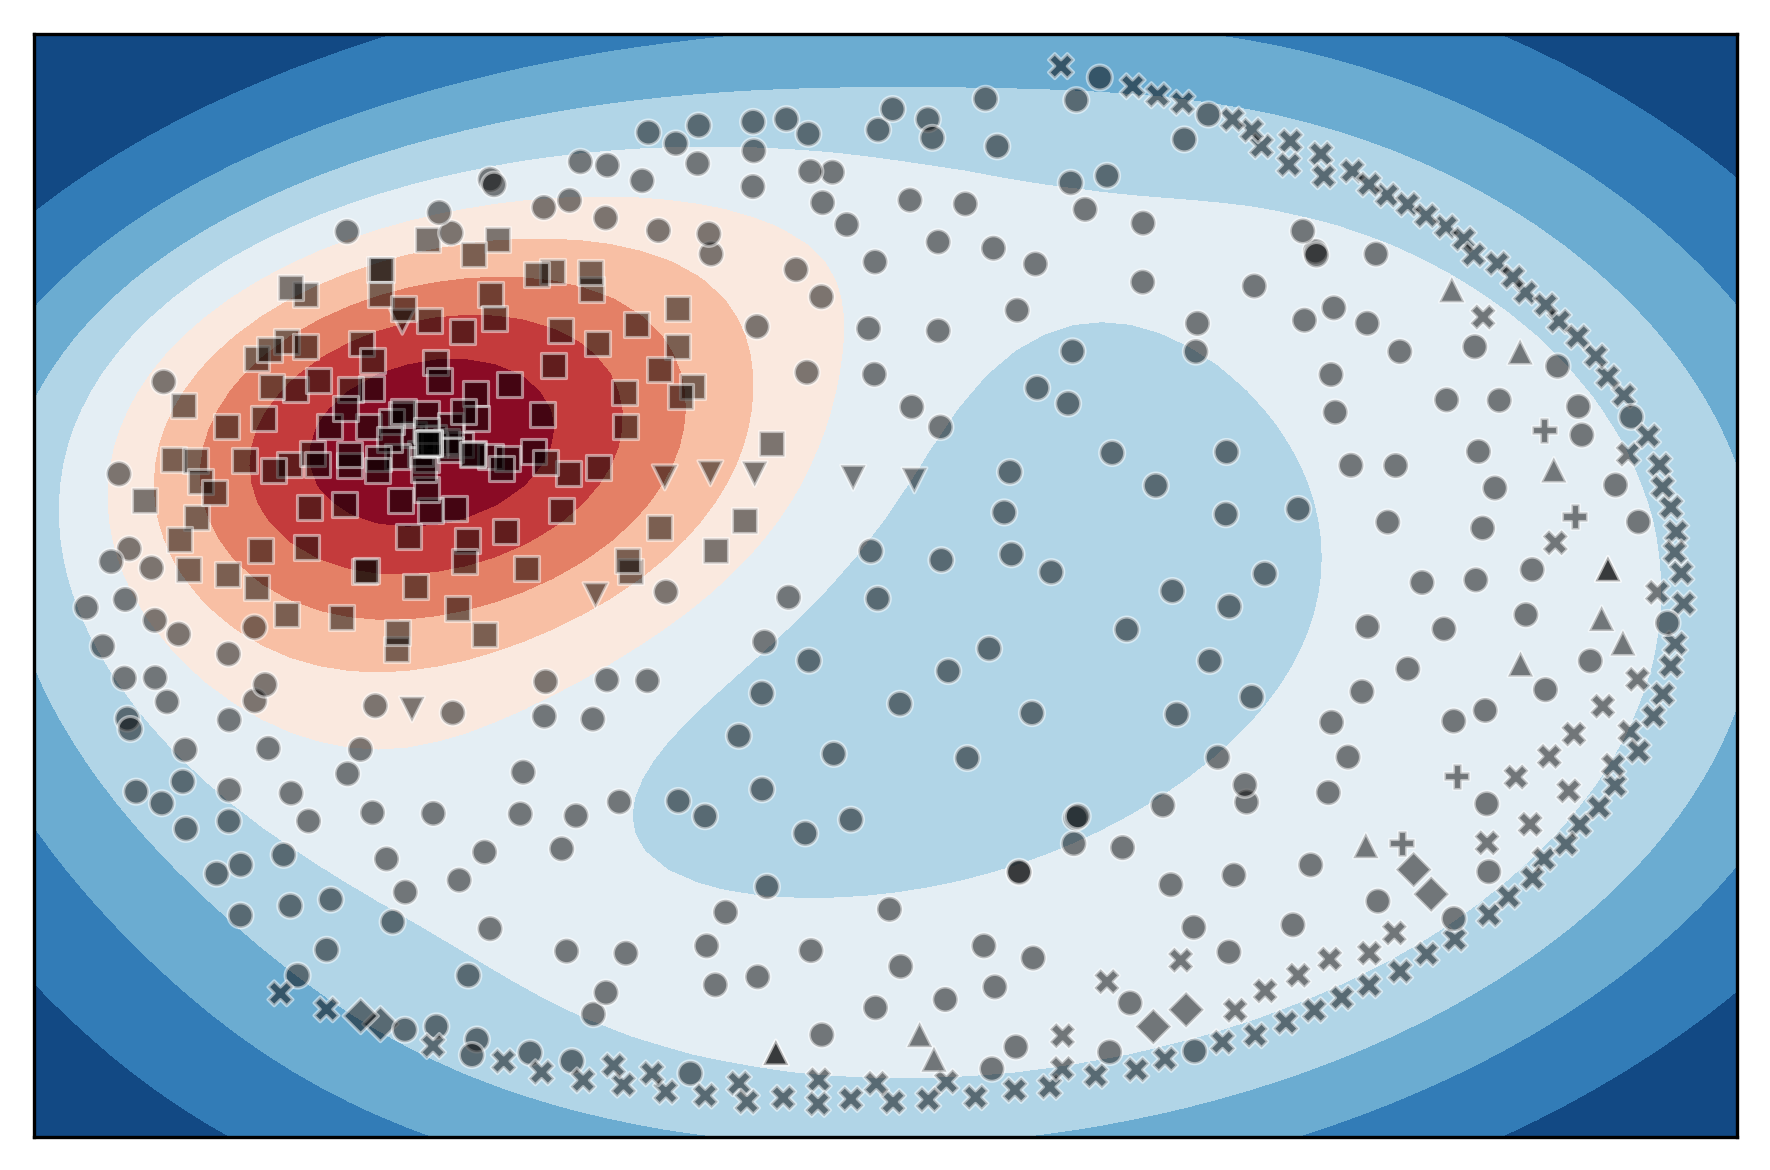

In [201]:
fig, ax = plt.subplots()

sns.kdeplot(constraintX, 
            constraintY,
            bw=0.2,
            n_levels=9,
            cmap='RdBu_r',
            shade=True,
            ax=ax,
           )

sns.scatterplot(x='x', 
                y='y',
                style='cluster',
#                hue='constraint_distance',
#                palette='RdBu_r',
                data=cluster_coords,
                alpha=0.5,
#                size='compatibility_count',
                color='black',
                legend=False,
                ax=ax);

ax.tick_params(axis='both',
               which='both',
               bottom=False,
               labelbottom=False,
               left=False,
               labelleft=False)
#ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(constraintX.min()-0.05, constraintX.max()+0.05)
ax.set_ylim(constraintY.min()-0.05, constraintY.max()+0.05)
fig.set_dpi(300)
fig.tight_layout()

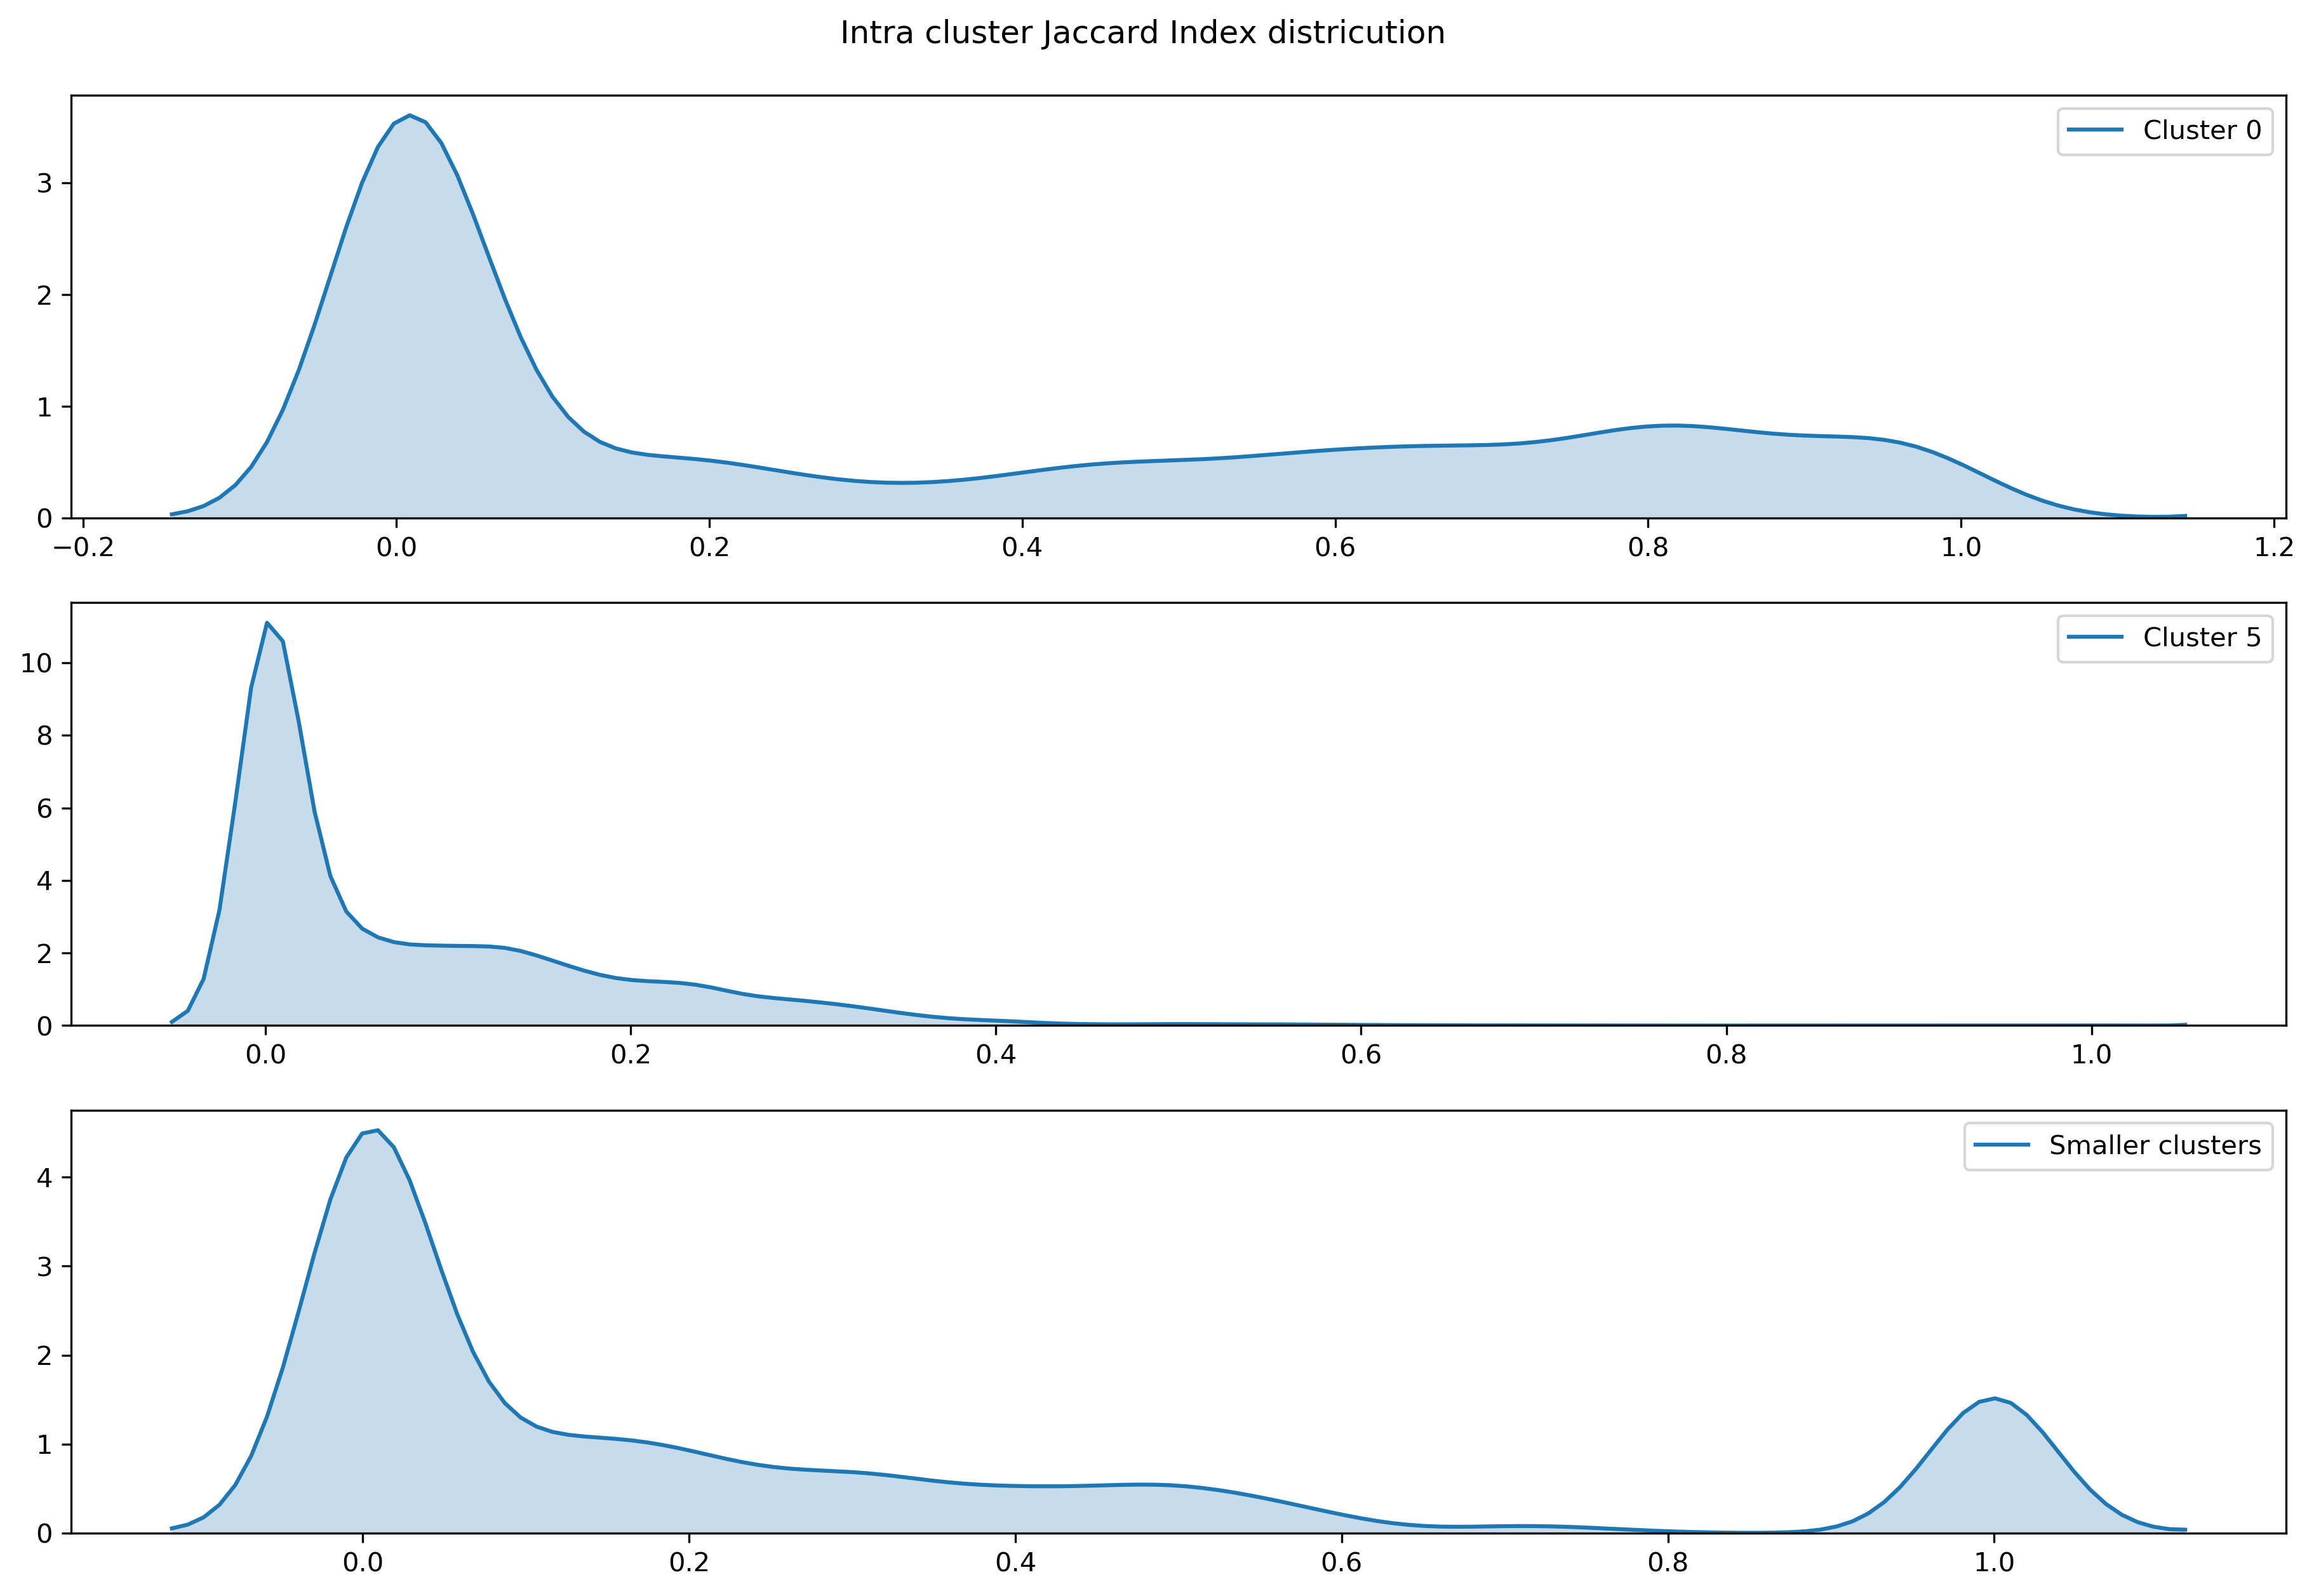

In [203]:
fig, axs = plt.subplots(nrows=3, figsize=(15,10))
for cluster_num, ax in zip([0, 5], axs):
    tmp = cluster_coords.index[cluster_coords.cluster==cluster_num]
    tmp_condensed = squareform(jaccard_distances.reindex(index=tmp, columns=tmp))
    sns.kdeplot(tmp_condensed, shade=True, ax=ax, label='Cluster %i' % cluster_num)

tmp           = cluster_coords.index[(cluster_coords.cluster!=0) &
                                     (cluster_coords.cluster!=1)]
tmp_condensed = squareform(jaccard_distances.reindex(index=tmp, columns=tmp))
sns.kdeplot(tmp_condensed, shade=True, ax=axs[2], label='Smaller clusters')
fig.suptitle('Intra cluster Jaccard Index districution', y=0.92)
fig.set_dpi(300)

In [221]:
tree.name = 'n1'

In [230]:
cluster0_compatibility.T.sum().max()

60

In [233]:
cluster0               = set(cluster_coords.query('cluster==0').index.tolist())
cluster0_compatibility = compatibility_table2[cluster0]

num_trees, num_constraints = cluster0_compatibility.shape
num_compatibles            = cluster0_compatibility.T.sum()

x = np.linspace(10, 60, 10)
y = []
target_node_ages = {'n1':[],
                    'n8':[],
                    'n117':[],
                    'n159':[]
                   }
target_node_descendants = {}
for node_name in target_node_ages:
    node = next(tree.iter_search_nodes(name=node_name))
    target_node_descendants[node_name] = node.get_leaf_names()

for thresh in x:
    compatible_trees = num_compatibles[num_compatibles >= thresh].index
    y.append(len(compatible_trees)/num_trees)

    for target_node in target_node_ages.keys():
        target_node_ages[target_node].append([])
    
    for tree_index, target_node in itertools.product(compatible_trees, target_node_ages.keys()):
        target_node_ages[target_node][-1].append(
            get_node_age_from_descendants(
                posterior_trees[tree_index],
                target_node_descendants[target_node]
            )
        )
y = np.array(y)

yeah


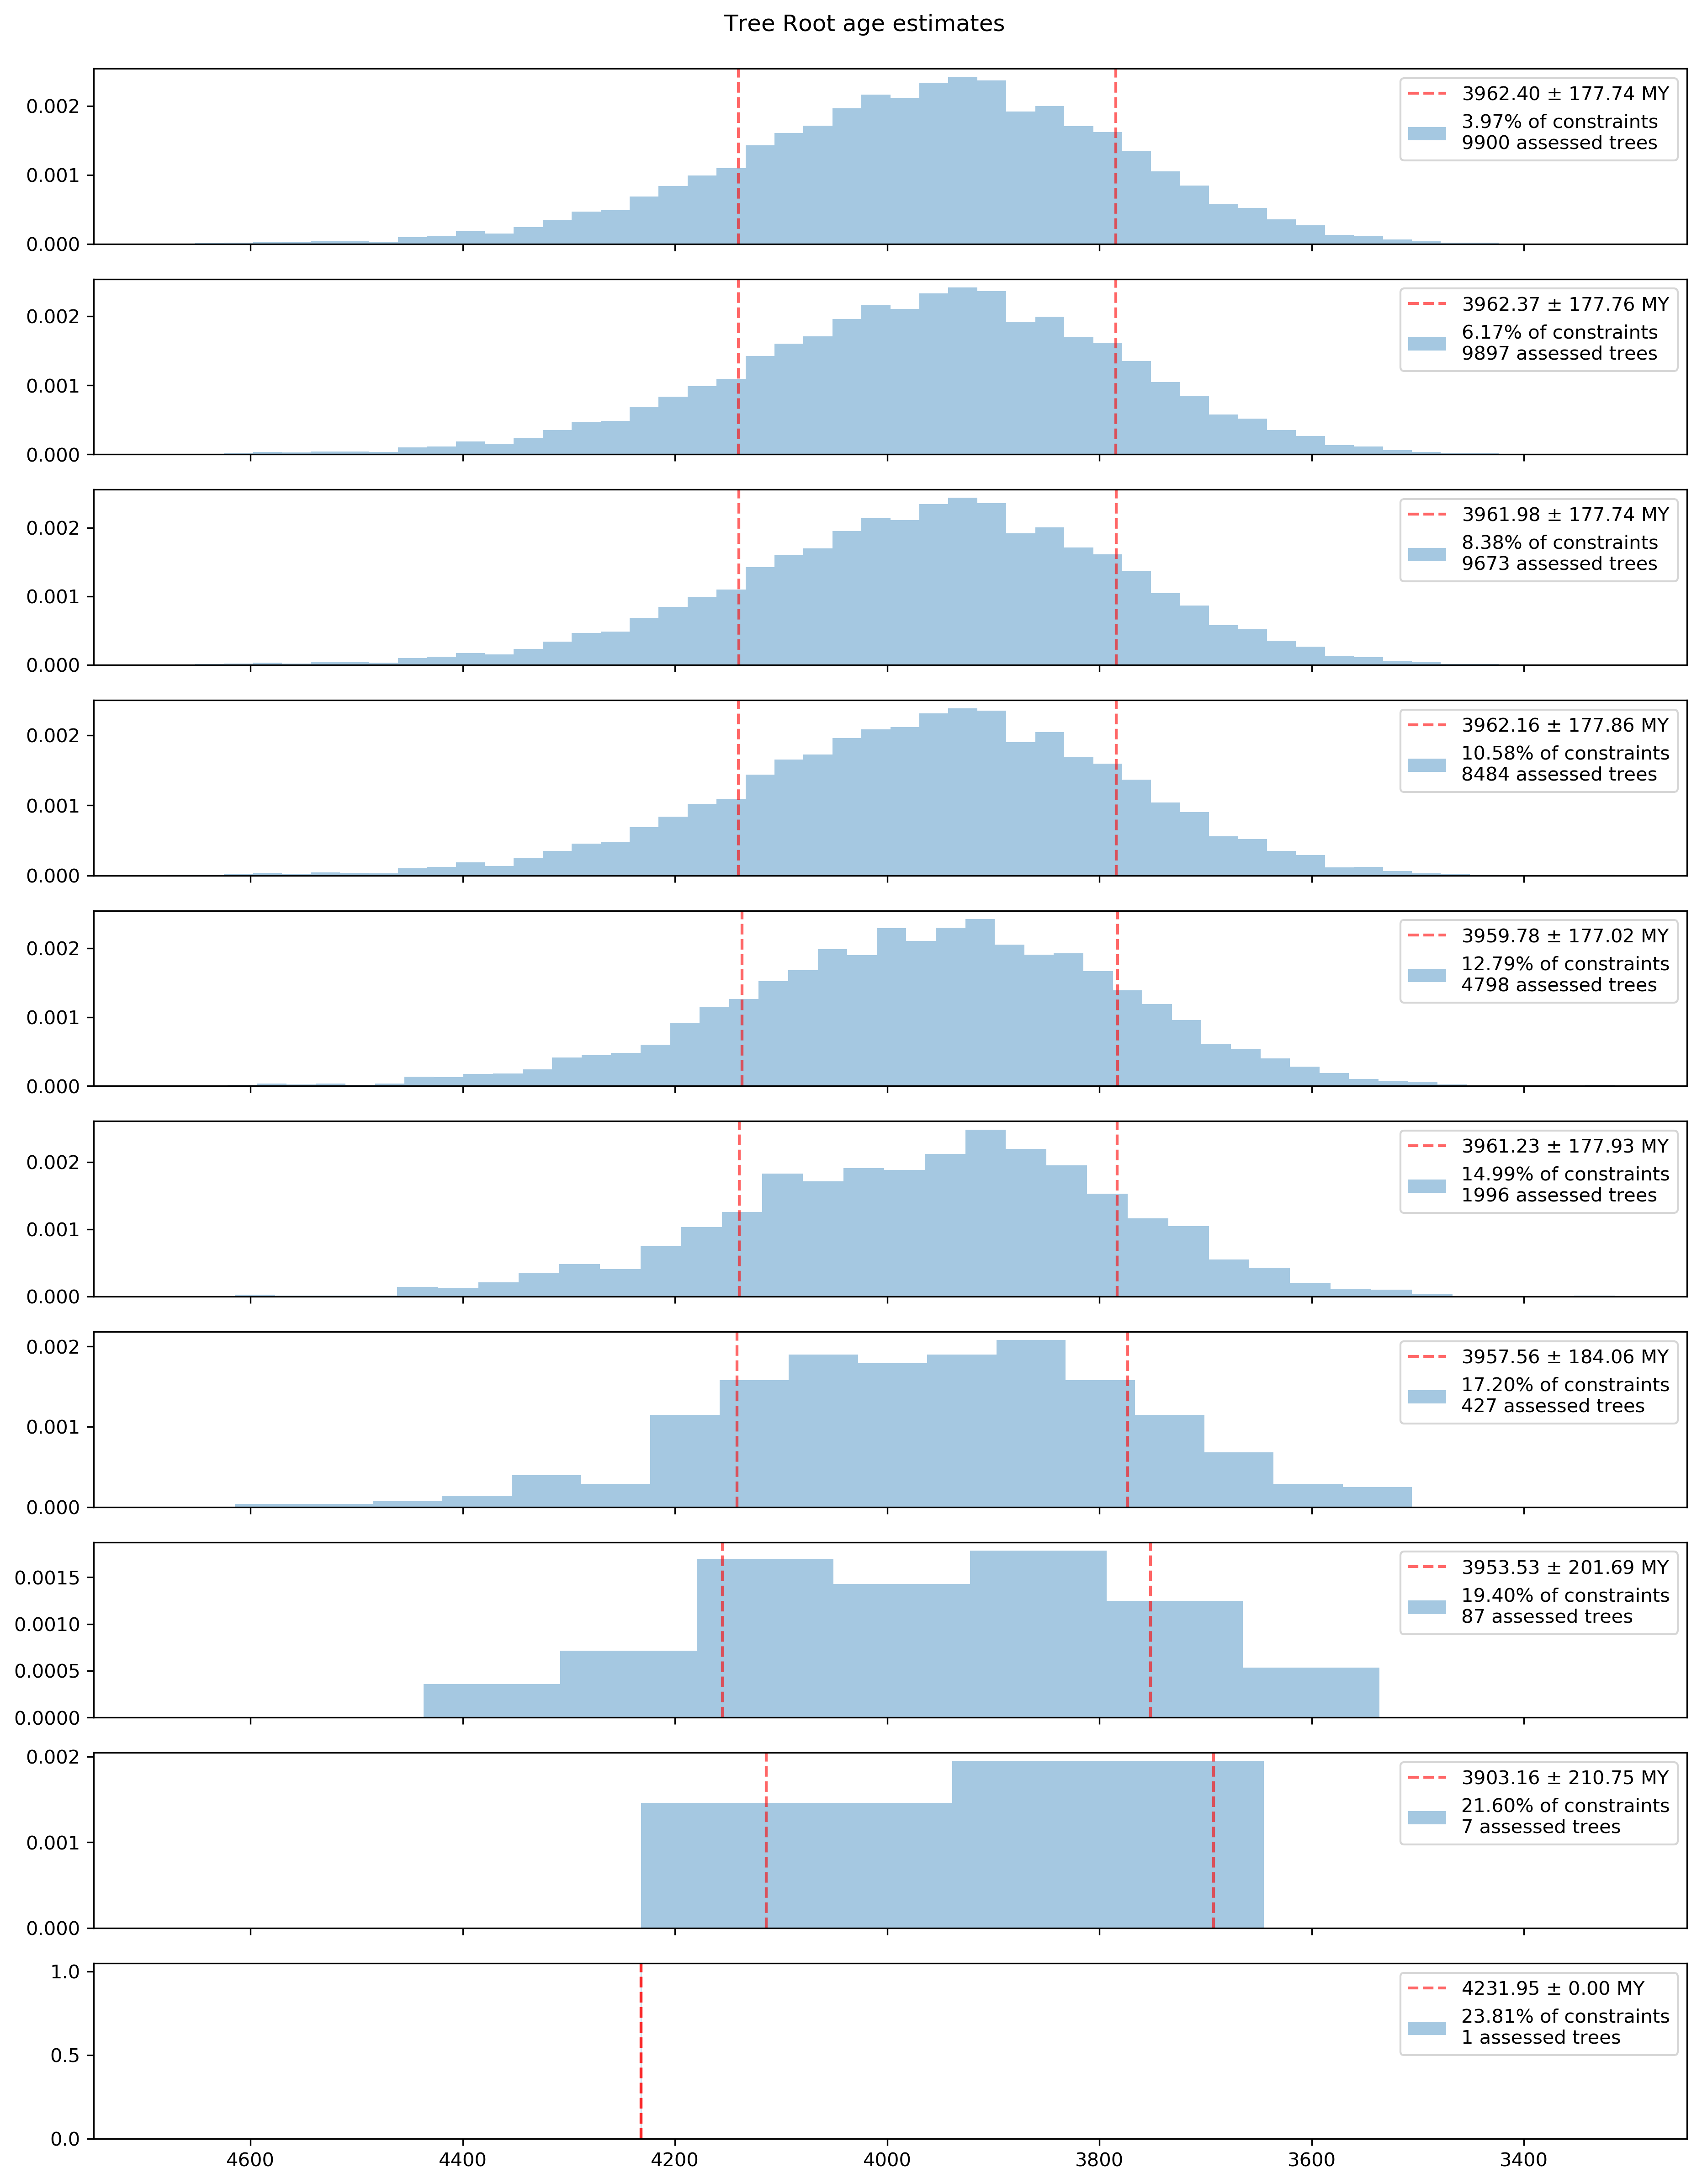

In [234]:
fig, axs = plt.subplots(figsize=(15,20),
                        dpi=300,
                        nrows=10,
                        sharex=True)

fig.suptitle('Tree Root age estimates', y=0.9)

for node_ages, thresh, ax in zip(target_node_ages['n1'], x, axs):
    sns.distplot(node_ages, kde=False,
#                shade=True,
                 norm_hist=True,
                 label='%.2f%% of constraints\n%i assessed trees' % \
                 ((thresh/num_constraints)*100, len(node_ages)),
                 ax=ax)
    ax.set_ylim(ax.axes.get_ylim())
    lower_std_bound = np.mean(node_ages) - np.std(node_ages)
    upper_std_bound = np.mean(node_ages) + np.std(node_ages)
    ax.plot([lower_std_bound, lower_std_bound],
            ax.axes.get_ylim(), 
            'r--', 
            alpha=0.6)
   
    ax.plot([upper_std_bound, upper_std_bound], 
            ax.axes.get_ylim(), 
            'r--', 
            alpha=0.6,
            label='%.2f $\pm$ %.2f MY' % (np.mean(node_ages), np.std(node_ages)))
    
    ax.legend()
ax.invert_xaxis()

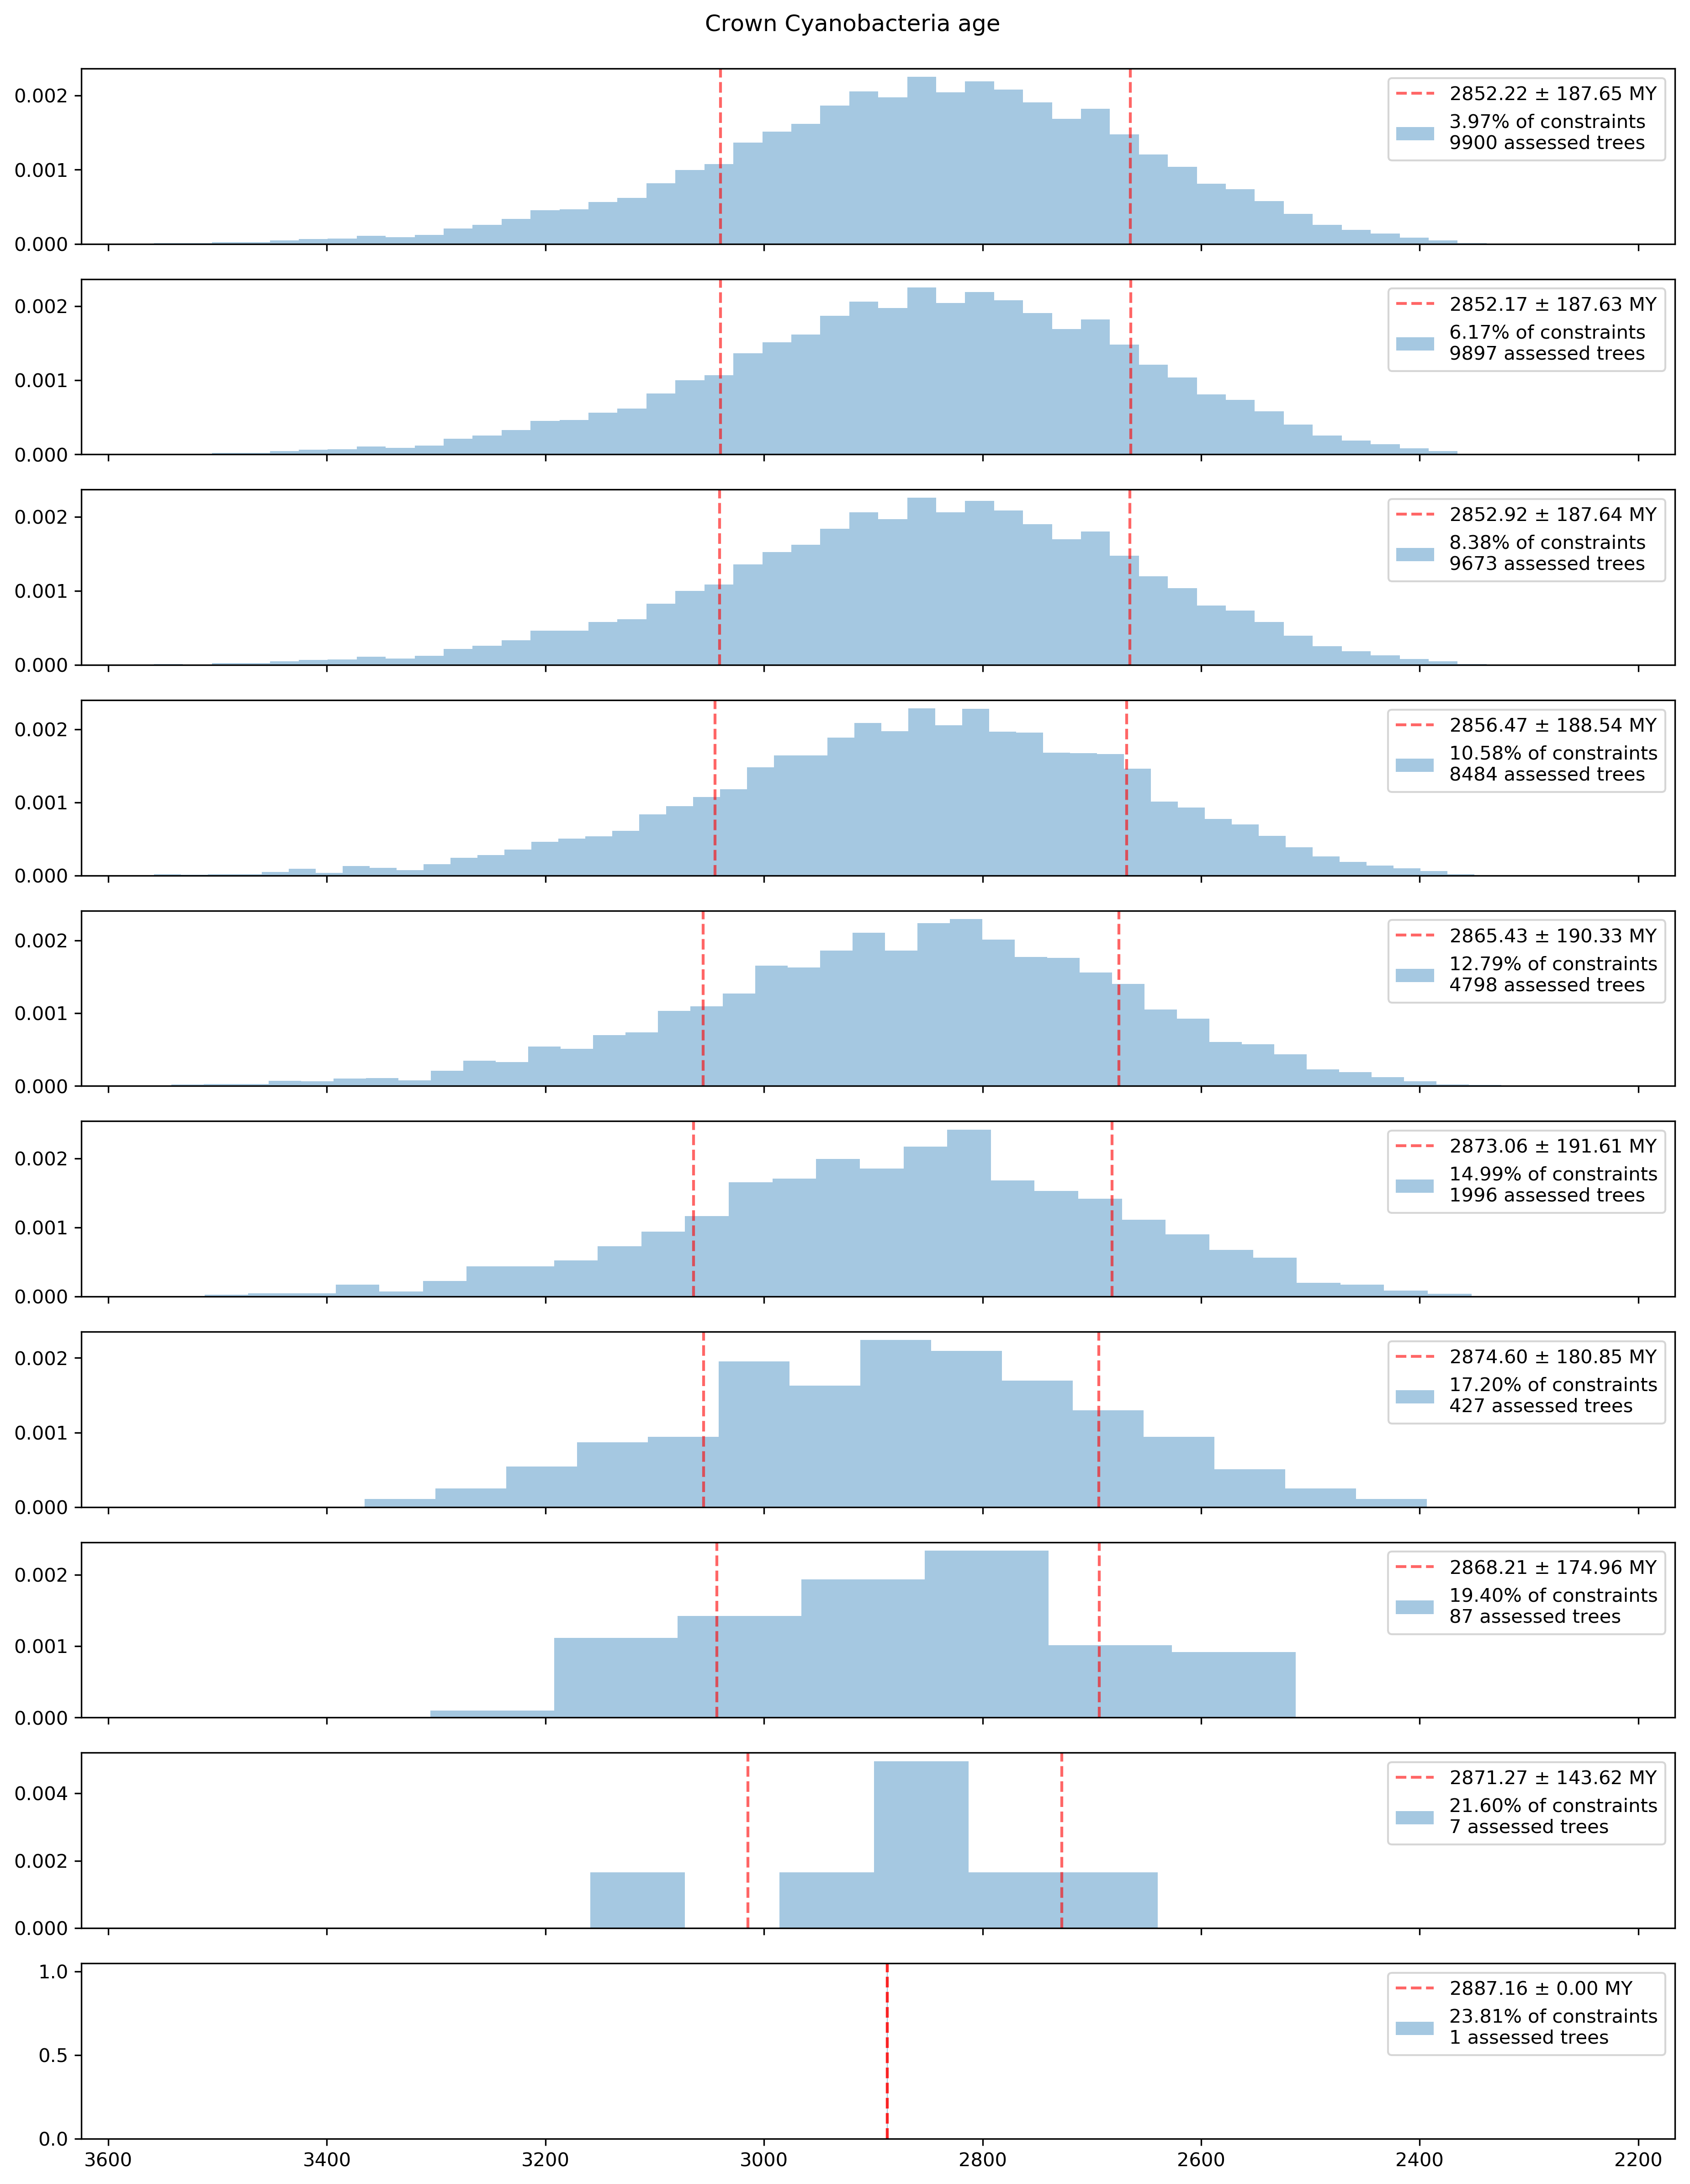

In [235]:
fig, axs = plt.subplots(figsize=(15,20),
                        dpi=300,
                        nrows=len(target_node_ages['n8']),
                        sharex=True)

fig.suptitle('Crown Cyanobacteria age', y=0.9)

for node_ages, thresh, ax in zip(target_node_ages['n8'], x, axs):
    sns.distplot(node_ages, kde=False,
#                shade=True,
                 norm_hist=True,
                 label='%.2f%% of constraints\n%i assessed trees' % \
                 ((thresh/num_constraints)*100, len(node_ages)),
                 ax=ax)
    ax.set_ylim(ax.axes.get_ylim())
    lower_std_bound = np.mean(node_ages) - np.std(node_ages)
    upper_std_bound = np.mean(node_ages) + np.std(node_ages)
    ax.plot([lower_std_bound, lower_std_bound],
            ax.axes.get_ylim(), 
            'r--', 
            alpha=0.6)
   
    ax.plot([upper_std_bound, upper_std_bound], 
            ax.axes.get_ylim(), 
            'r--', 
            alpha=0.6,
            label='%.2f $\pm$ %.2f MY' % (np.mean(node_ages), np.std(node_ages)))
    
    ax.legend()
ax.invert_xaxis()

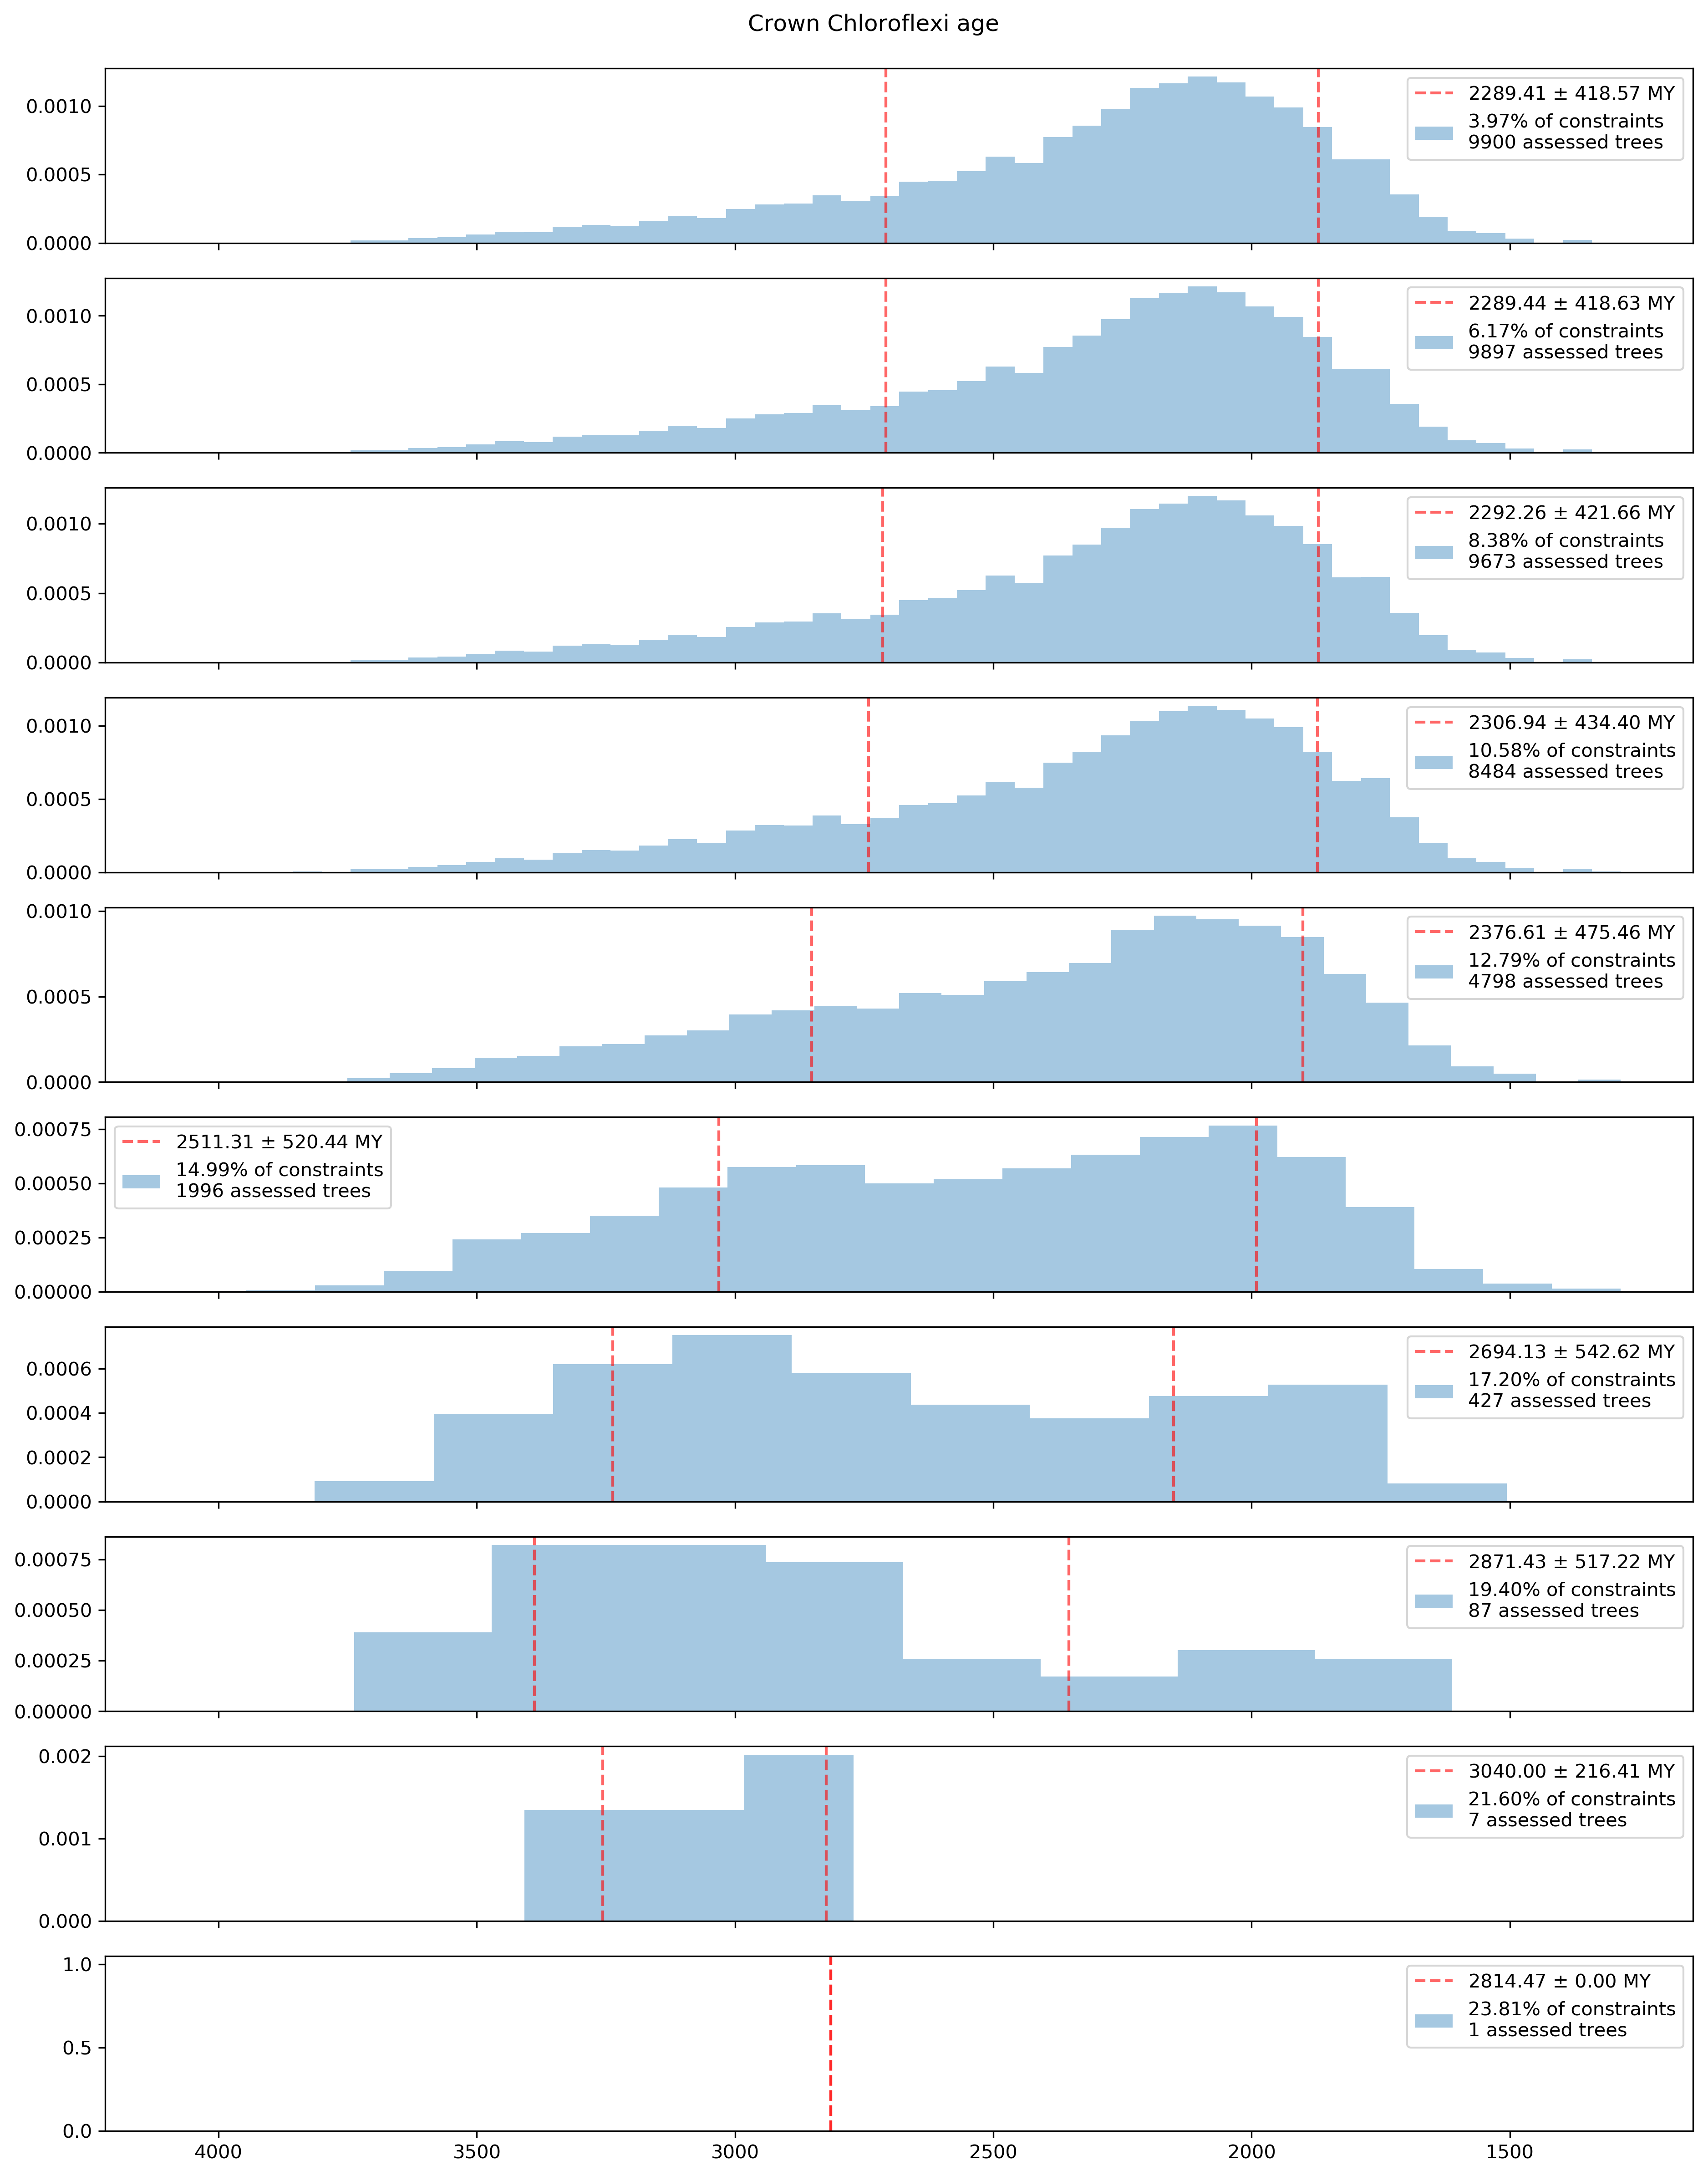

In [236]:
fig, axs = plt.subplots(figsize=(15,20),
                        dpi=300,
                        nrows=len(target_node_ages['n117']),
                        sharex=True)

fig.suptitle('Crown Chloroflexi age', y=0.9)

for node_ages, thresh, ax in zip(target_node_ages['n117'], x, axs):
    sns.distplot(node_ages, kde=False,
#                shade=True,
                 norm_hist=True,
                 label='%.2f%% of constraints\n%i assessed trees' % \
                 ((thresh/num_constraints)*100, len(node_ages)),
                 ax=ax)
    ax.set_ylim(ax.axes.get_ylim())
    lower_std_bound = np.mean(node_ages) - np.std(node_ages)
    upper_std_bound = np.mean(node_ages) + np.std(node_ages)
    ax.plot([lower_std_bound, lower_std_bound],
            ax.axes.get_ylim(), 
            'r--', 
            alpha=0.6)
   
    ax.plot([upper_std_bound, upper_std_bound], 
            ax.axes.get_ylim(), 
            'r--', 
            alpha=0.6,
            label='%.2f $\pm$ %.2f MY' % (np.mean(node_ages), np.std(node_ages)))
    
    ax.legend()
ax.invert_xaxis()

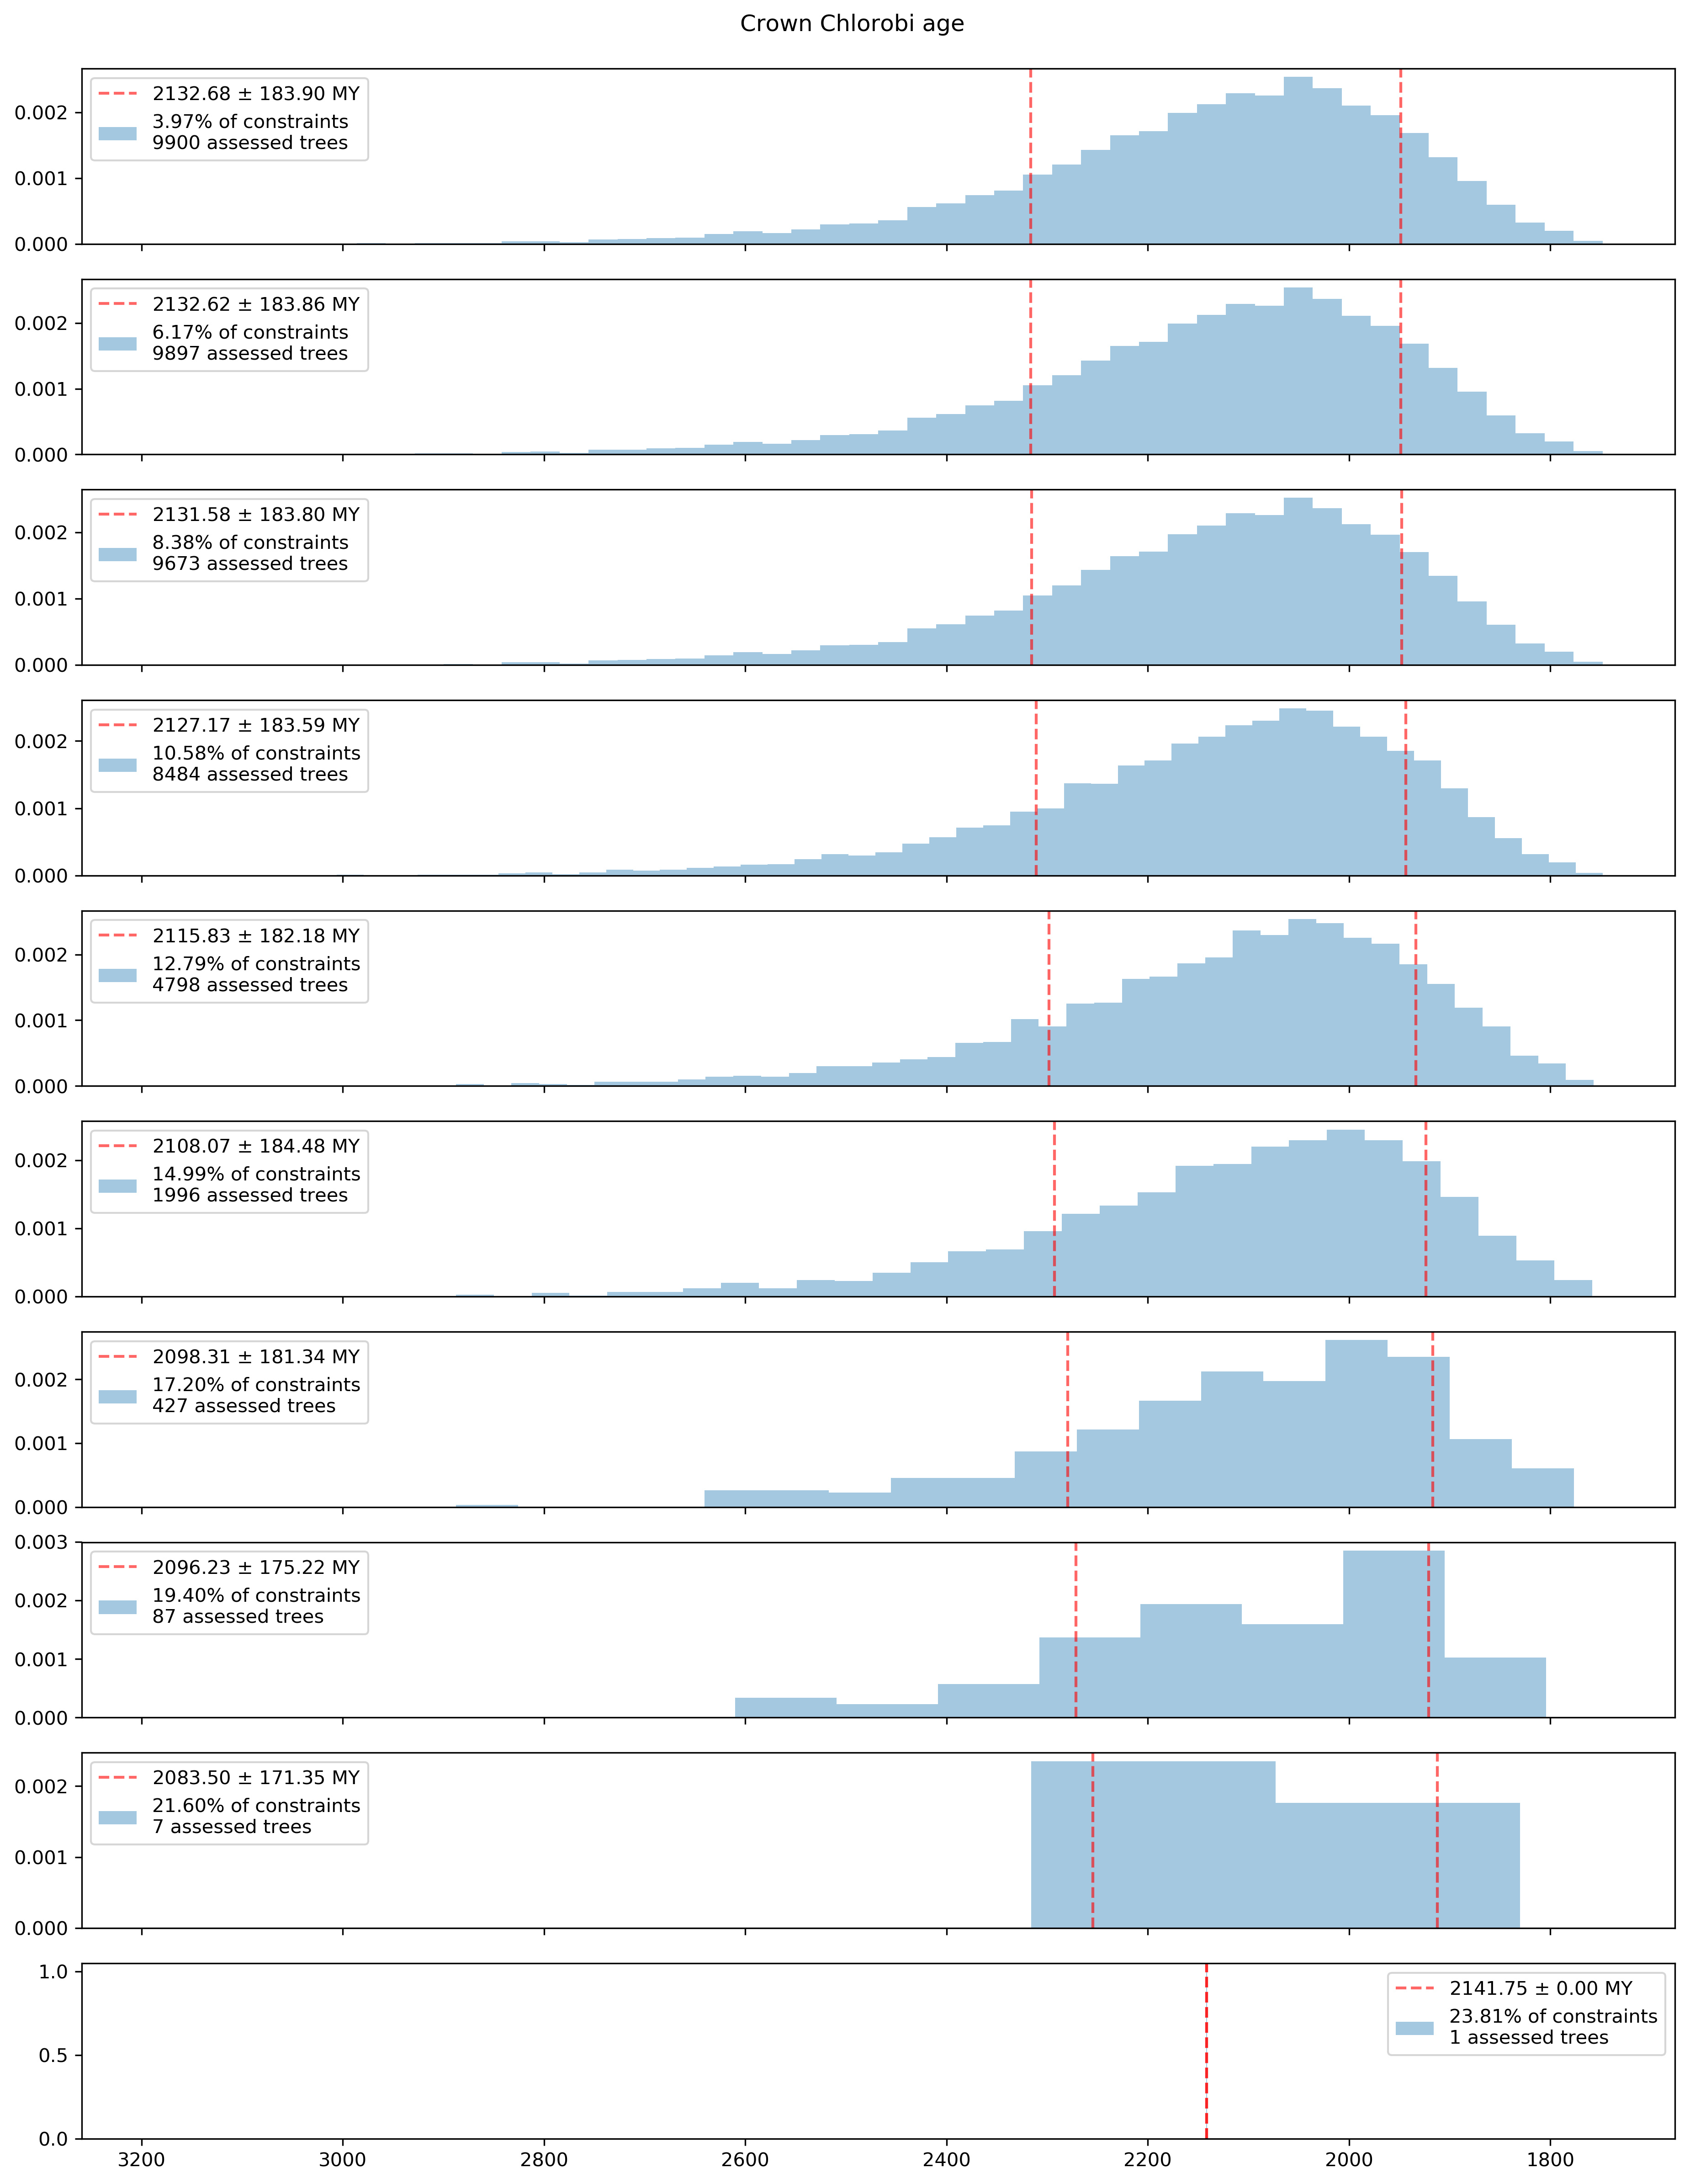

In [237]:
fig, axs = plt.subplots(figsize=(15,20),
                        dpi=300,
                        nrows=len(target_node_ages['n159']),
                        sharex=True)

fig.suptitle('Crown Chlorobi age', y=0.9)

for node_ages, thresh, ax in zip(target_node_ages['n159'], x, axs):
    sns.distplot(node_ages, kde=False,
#                shade=True,
                 norm_hist=True,
                 label='%.2f%% of constraints\n%i assessed trees' % \
                 ((thresh/num_constraints)*100, len(node_ages)),
                ax=ax)
    ax.set_ylim(ax.axes.get_ylim())
    lower_std_bound = np.mean(node_ages) - np.std(node_ages)
    upper_std_bound = np.mean(node_ages) + np.std(node_ages)
    ax.plot([lower_std_bound, lower_std_bound],
            ax.axes.get_ylim(), 
            'r--', 
            alpha=0.6)
   
    ax.plot([upper_std_bound, upper_std_bound], 
            ax.axes.get_ylim(), 
            'r--', 
            alpha=0.6,
            label='%.2f $\pm$ %.2f MY' % (np.mean(node_ages), np.std(node_ages)))
    
    ax.legend()
ax.invert_xaxis()

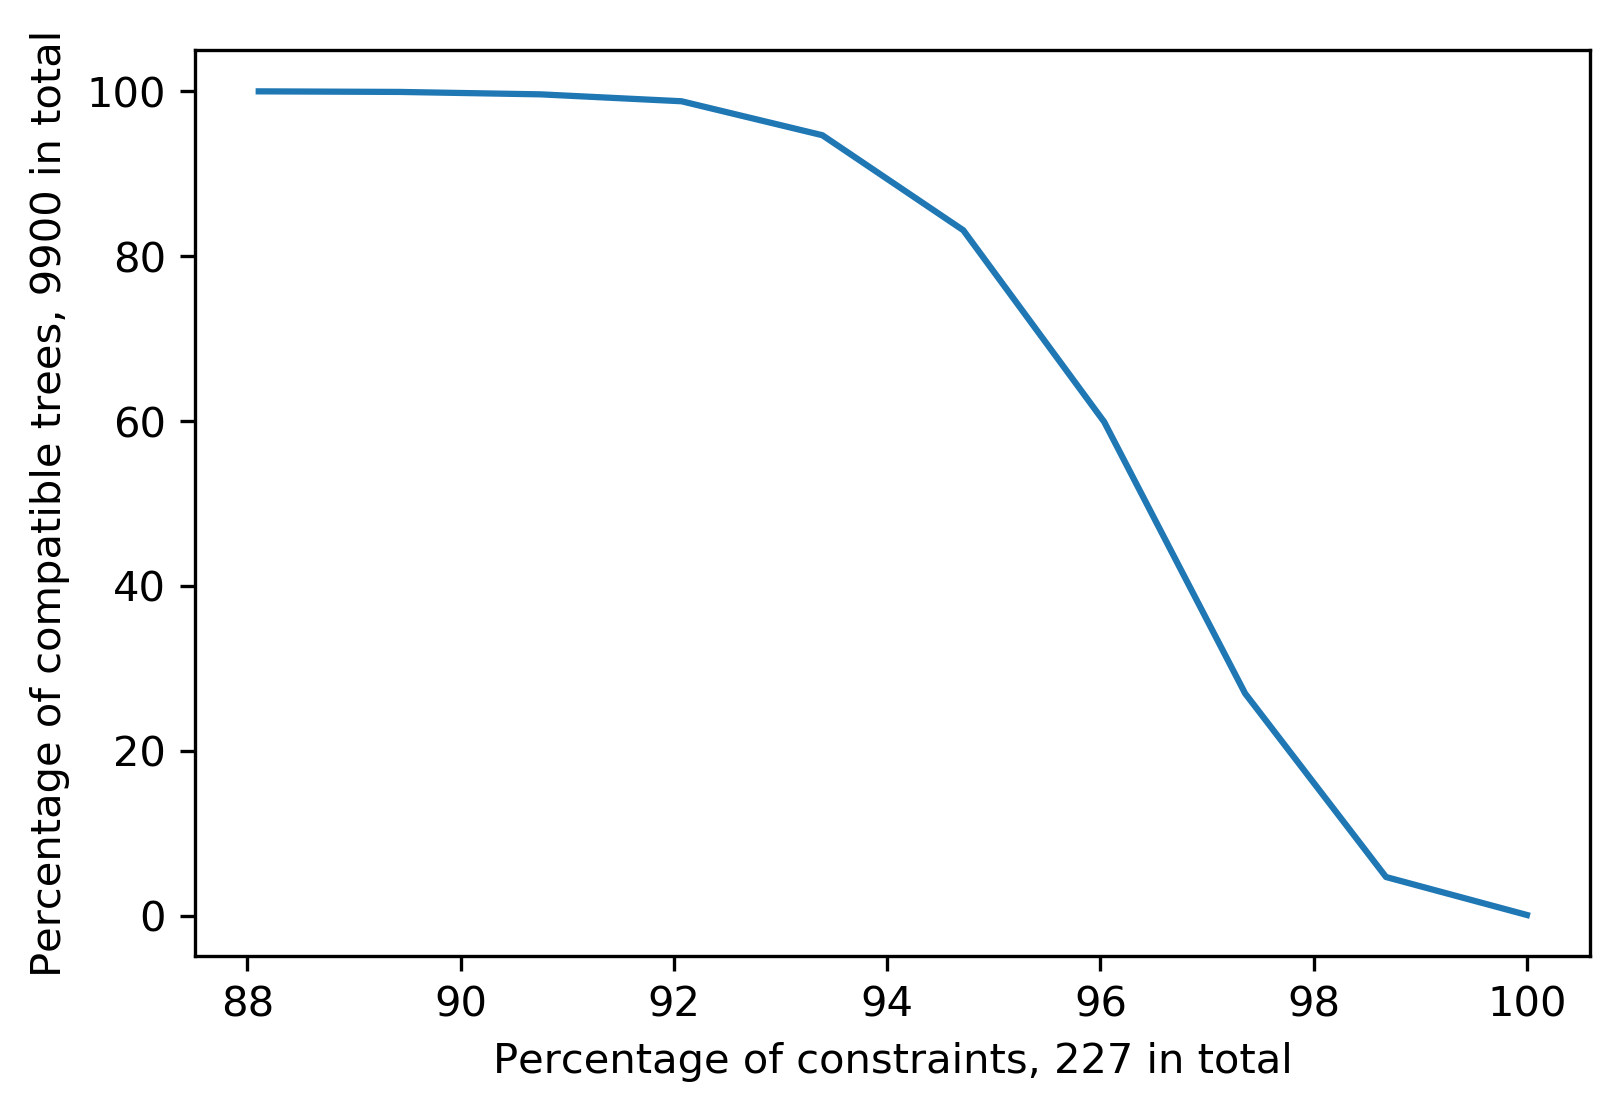

In [50]:
fig, ax = plt.subplots(dpi=300)
ax.set_xlabel('Percentage of constraints, %i in total' % num_constraints)
ax.set_ylabel('Percentage of compatible trees, %i in total' % num_trees)
ax.plot((x/num_constraints)*100,
        y*100);

In [28]:
cluster0_coords = cluster_coords.loc[cluster0].copy()
cluster0_coords.sort_values(by='constraint_distance', ascending=False, inplace=True)

In [29]:
cluster0_coords.iloc[:5]

x         y cluster  cluster_size  compatibility_count  \
(n153, n43)  -0.074736 -0.266254       0           227                 9656   
(n114, n168) -0.083202 -0.267861       0           227                 9733   
(n137, n43)  -0.089754 -0.317725       0           227                 9261   
(n77, n168)  -0.069981 -0.292699       0           227                 9548   
(n144, n113) -0.083164 -0.277383       0           227                 9900   

              constraint_support  constraint_distance  
(n153, n43)                    1             2.421620  
(n114, n168)                   1             2.336984  
(n137, n43)                    3             2.321203  
(n77, n168)                    1             2.002586  
(n144, n113)                   1             1.997479

In [30]:
cluster0_coords.iloc[-5:]

x         y cluster  cluster_size  compatibility_count  \
(n96, n77)   -0.065871 -0.289165       0           227                 9560   
(n81, n71)   -0.026797 -0.252330       0           227                 8984   
(n70, n47)   -0.107211 -0.300421       0           227                 9365   
(n81, n75)   -0.074735 -0.252804       0           227                 9464   
(n165, n168) -0.095277 -0.163030       0           227                 8219   

              constraint_support  constraint_distance  
(n96, n77)                     1             0.124887  
(n81, n71)                     1             0.122510  
(n70, n47)                     1             0.115212  
(n81, n75)                     1             0.101823  
(n165, n168)                  20             0.096659

In [31]:
mt_black = set()
mt_green = set()
for line in open('maxtic.input_MT_output_partial_order').readlines():
    line = line.split()
    if line[-1] == 'black':
        mt_black.add((line[0], line[1]))
    else:
        mt_green.add((line[0], line[1]))
mt = mt_black.union(mt_green)

cluster0 = set(cluster_coords.query('cluster==0').index.tolist())
cluster1 = set(cluster_coords.query('cluster==1').index.tolist())

In [32]:
print('MaxTic VS this thing we are doing: %.4f' % 
      (len(mt.intersection(cluster0))/len(mt.union(cluster0)))
     )
print('MaxTic BLACK VS this thing we are doing: %.4f' % 
      (len(mt_black.intersection(cluster0))/len(mt_black.union(cluster0)))
     )
print('MaxTic GREEN VS this thing we are doing: %.4f' % 
      (len(mt_green.intersection(cluster0))/len(mt_green.union(cluster0)))
     )

MaxTic VS this thing we are doing: 0.4975
MaxTic BLACK VS this thing we are doing: 0.5655
MaxTic GREEN VS this thing we are doing: 0.0645


In [151]:
highpass_constraints = [
    (292, 268), (310, 324), (309, 294), (328, 319),
    (286, 179), (289, 312), (290, 281), (290, 224),
    (290, 327), (290, 177), (290, 179), (290, 303),
    (287, 177), (287, 179), (281, 338), (303, 322)
]

In [82]:
pb_named_tree = ete3.Tree(
    '/Users/thiberio/Dropbox (MIT)/modeldata/Cyano_modelBC_ugam_bd_7_20_payette_corrected.labels.txt',
     format=1)
for node in pb_named_tree.traverse():
    if node.is_leaf():
        continue
    
    equivalent = tree.get_common_ancestor(node.get_leaf_names())
    equivalent.add_feature('pb_name', node.name)

In [93]:
def assess_constraint_compatibility_pb(constraint):
    older_bound   = next(tree.iter_search_nodes(pb_name=str(constraint[0])))
    younger_bound = next(tree.iter_search_nodes(pb_name=str(constraint[1])))
    
#    older_bound   = next(older_bound.iter_ancestors())
#    younger_bound = next(younger_bound.iter_ancestors())
    
    compatibilities = []
    for tmp_tree in posterior_trees:
        older_bound_age   = get_node_age_from_descendants(tmp_tree,   older_bound.get_leaf_names())
        younger_bound_age = get_node_age_from_descendants(tmp_tree, younger_bound.get_leaf_names())
        
        if older_bound_age > younger_bound_age:
            compatibilities.append(True)
        else:
            compatibilities.append(False)

    return(compatibilities)

In [92]:
pool    = multiprocessing.Pool(processes=5)
results = pool.map(assess_constraint_compatibility_pb, highpass_constraints)

for n in results:
    print(sum(n))

1592
7039
9892
9900
9900
8863
9897
9900
9341
205
579
8193
1163
2240
9900
9900


In [152]:
pool    = multiprocessing.Pool(processes=5)
results2 = pool.map(assess_constraint_compatibility_pb, highpass_constraints)

for n in results2:
    print(sum(n))

44
9900
7862
9900
2240
6650
9817
9900
8413
4
36
4873
143
399
9825
9522


In [154]:
highpass_constraints_compatibilities = pd.DataFrame(index=highpass_constraints,
                                                    data   =results2).T

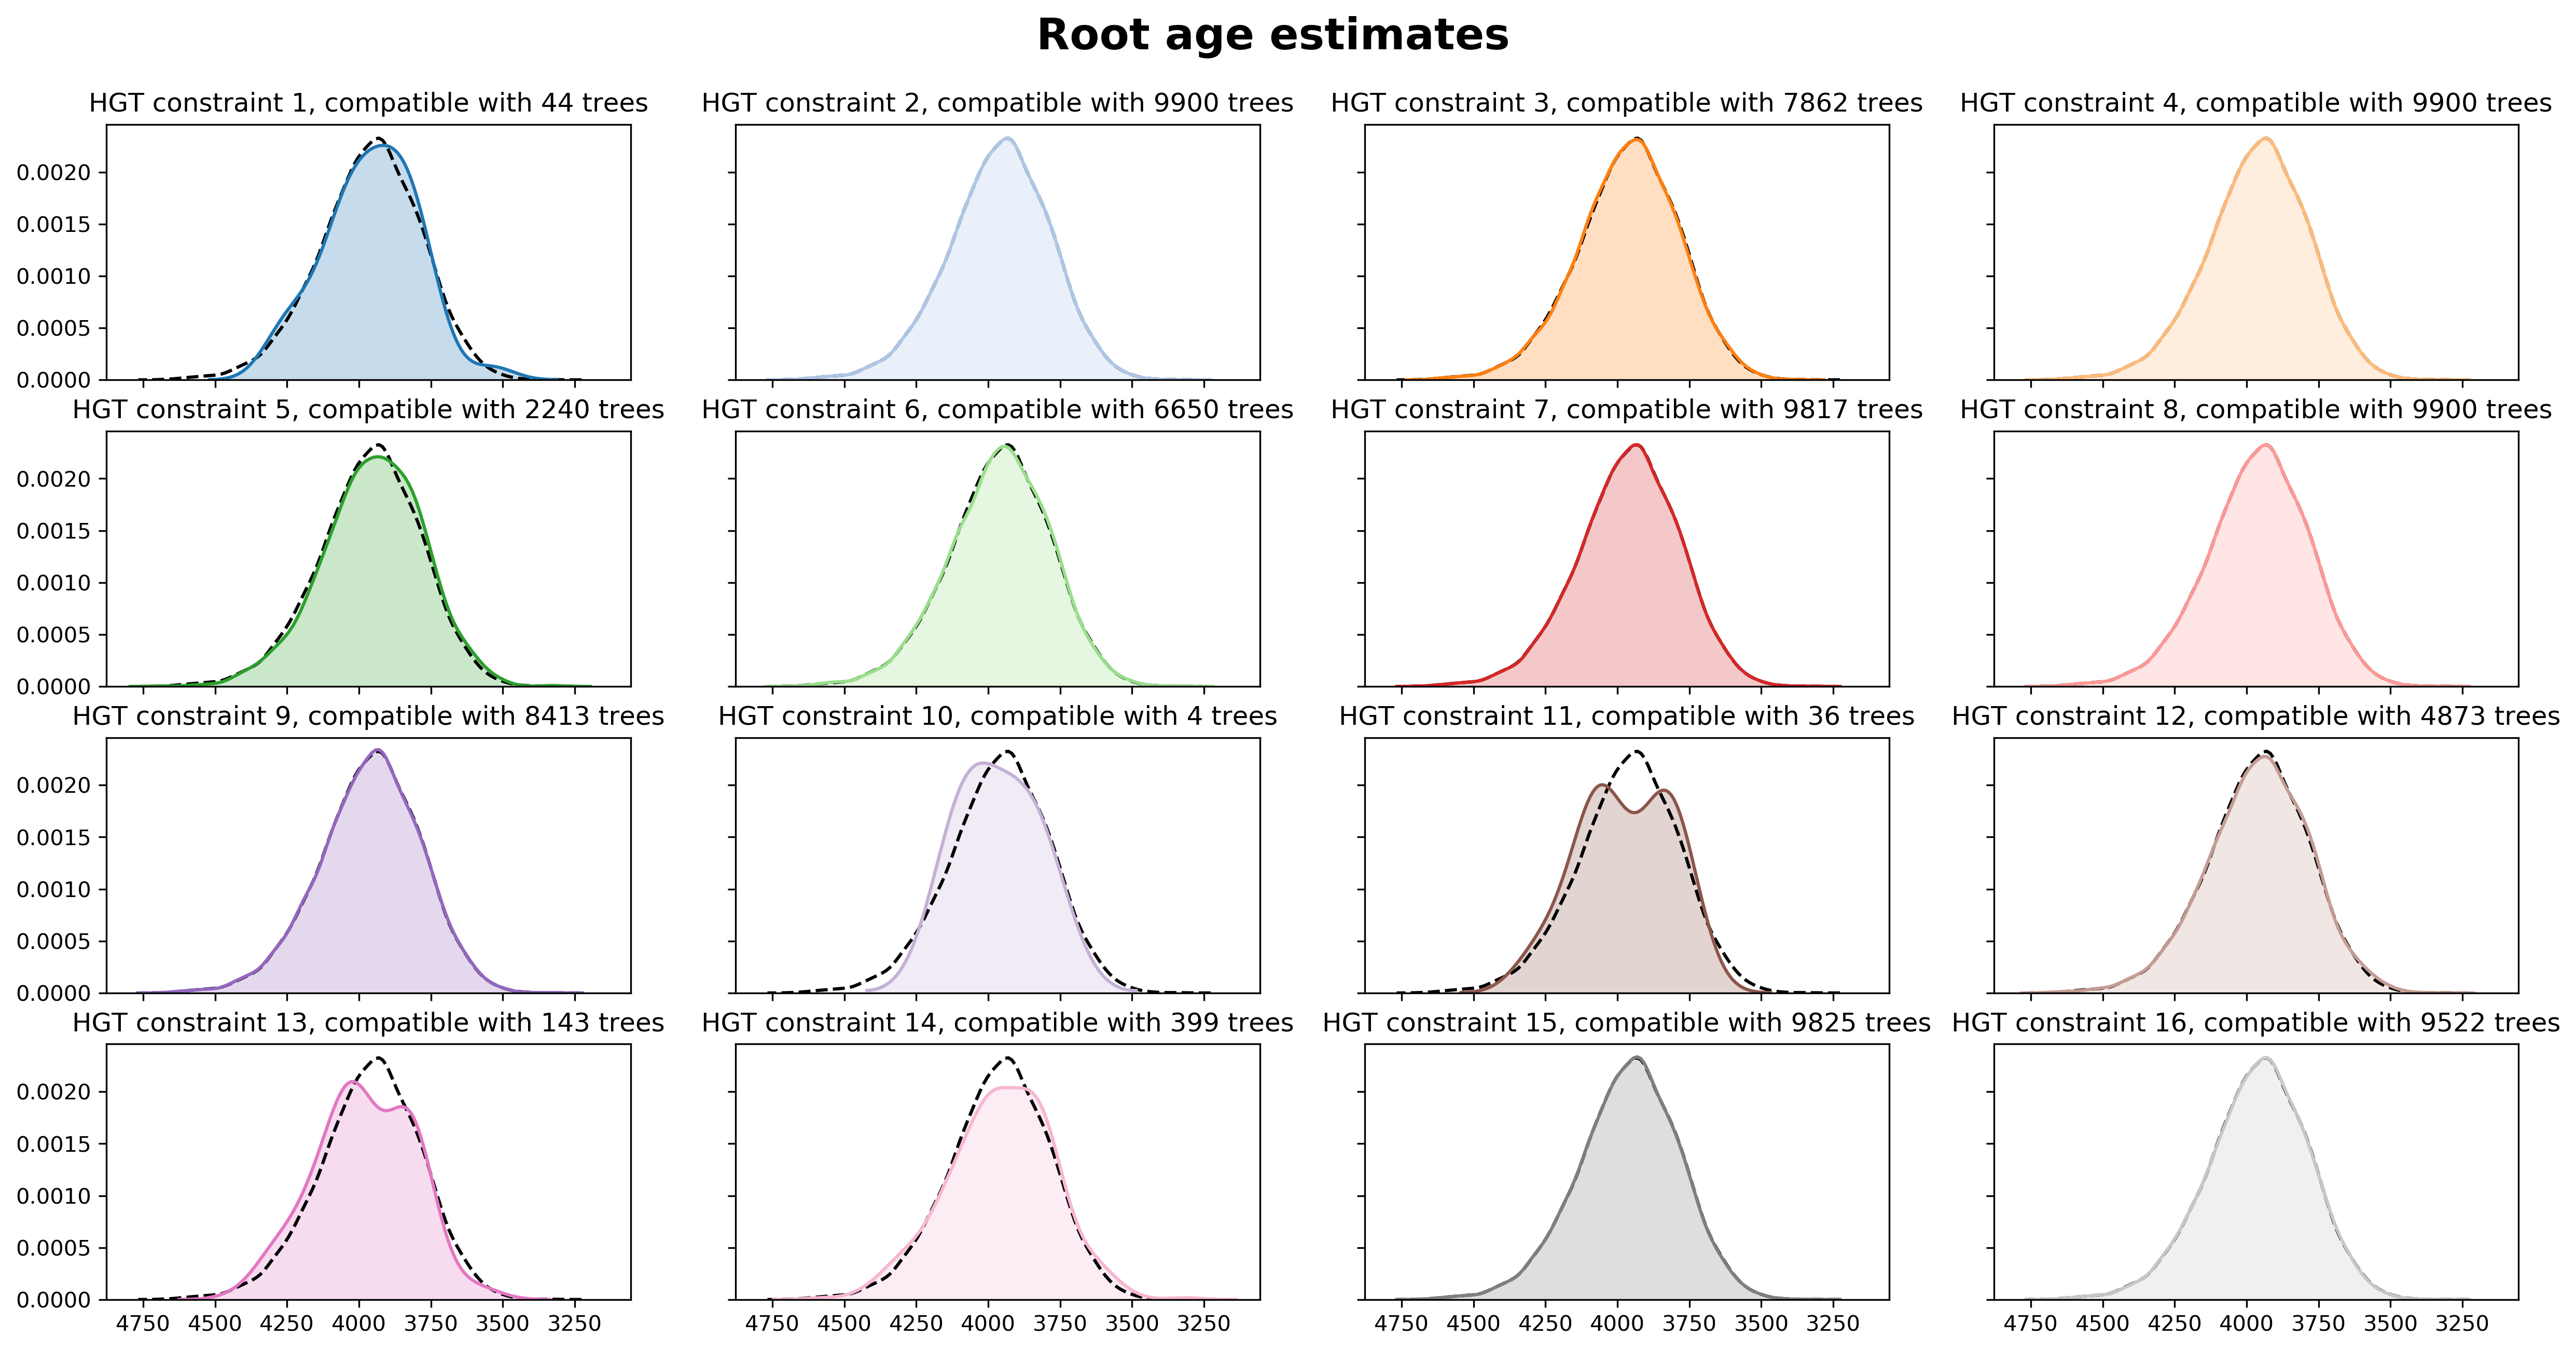

In [181]:
root_ages = np.array([tmp_tree.support for tmp_tree in posterior_trees])

fig, axs = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, dpi=300, figsize=(20,10))
count    = 1
colors = sns.color_palette("tab20", 16)
for ax, (constraint, compatibilities) in zip(itertools.chain.from_iterable(axs),
                                             highpass_constraints_compatibilities.iteritems()):
    sns.kdeplot(root_ages,
                ax=ax,
                shade=False,
               color = 'black',
               linestyle="--")

    sns.kdeplot(root_ages[compatibilities.tolist()],
                ax=ax,
                shade=True,
               color = colors[count-1])
    ax.set_title('HGT constraint %i, compatible with %i trees' % (count, compatibilities.sum()))
    count += 1
fig.suptitle('Root age estimates', y=0.95, fontsize=20, fontweight='bold')
ax.invert_xaxis()

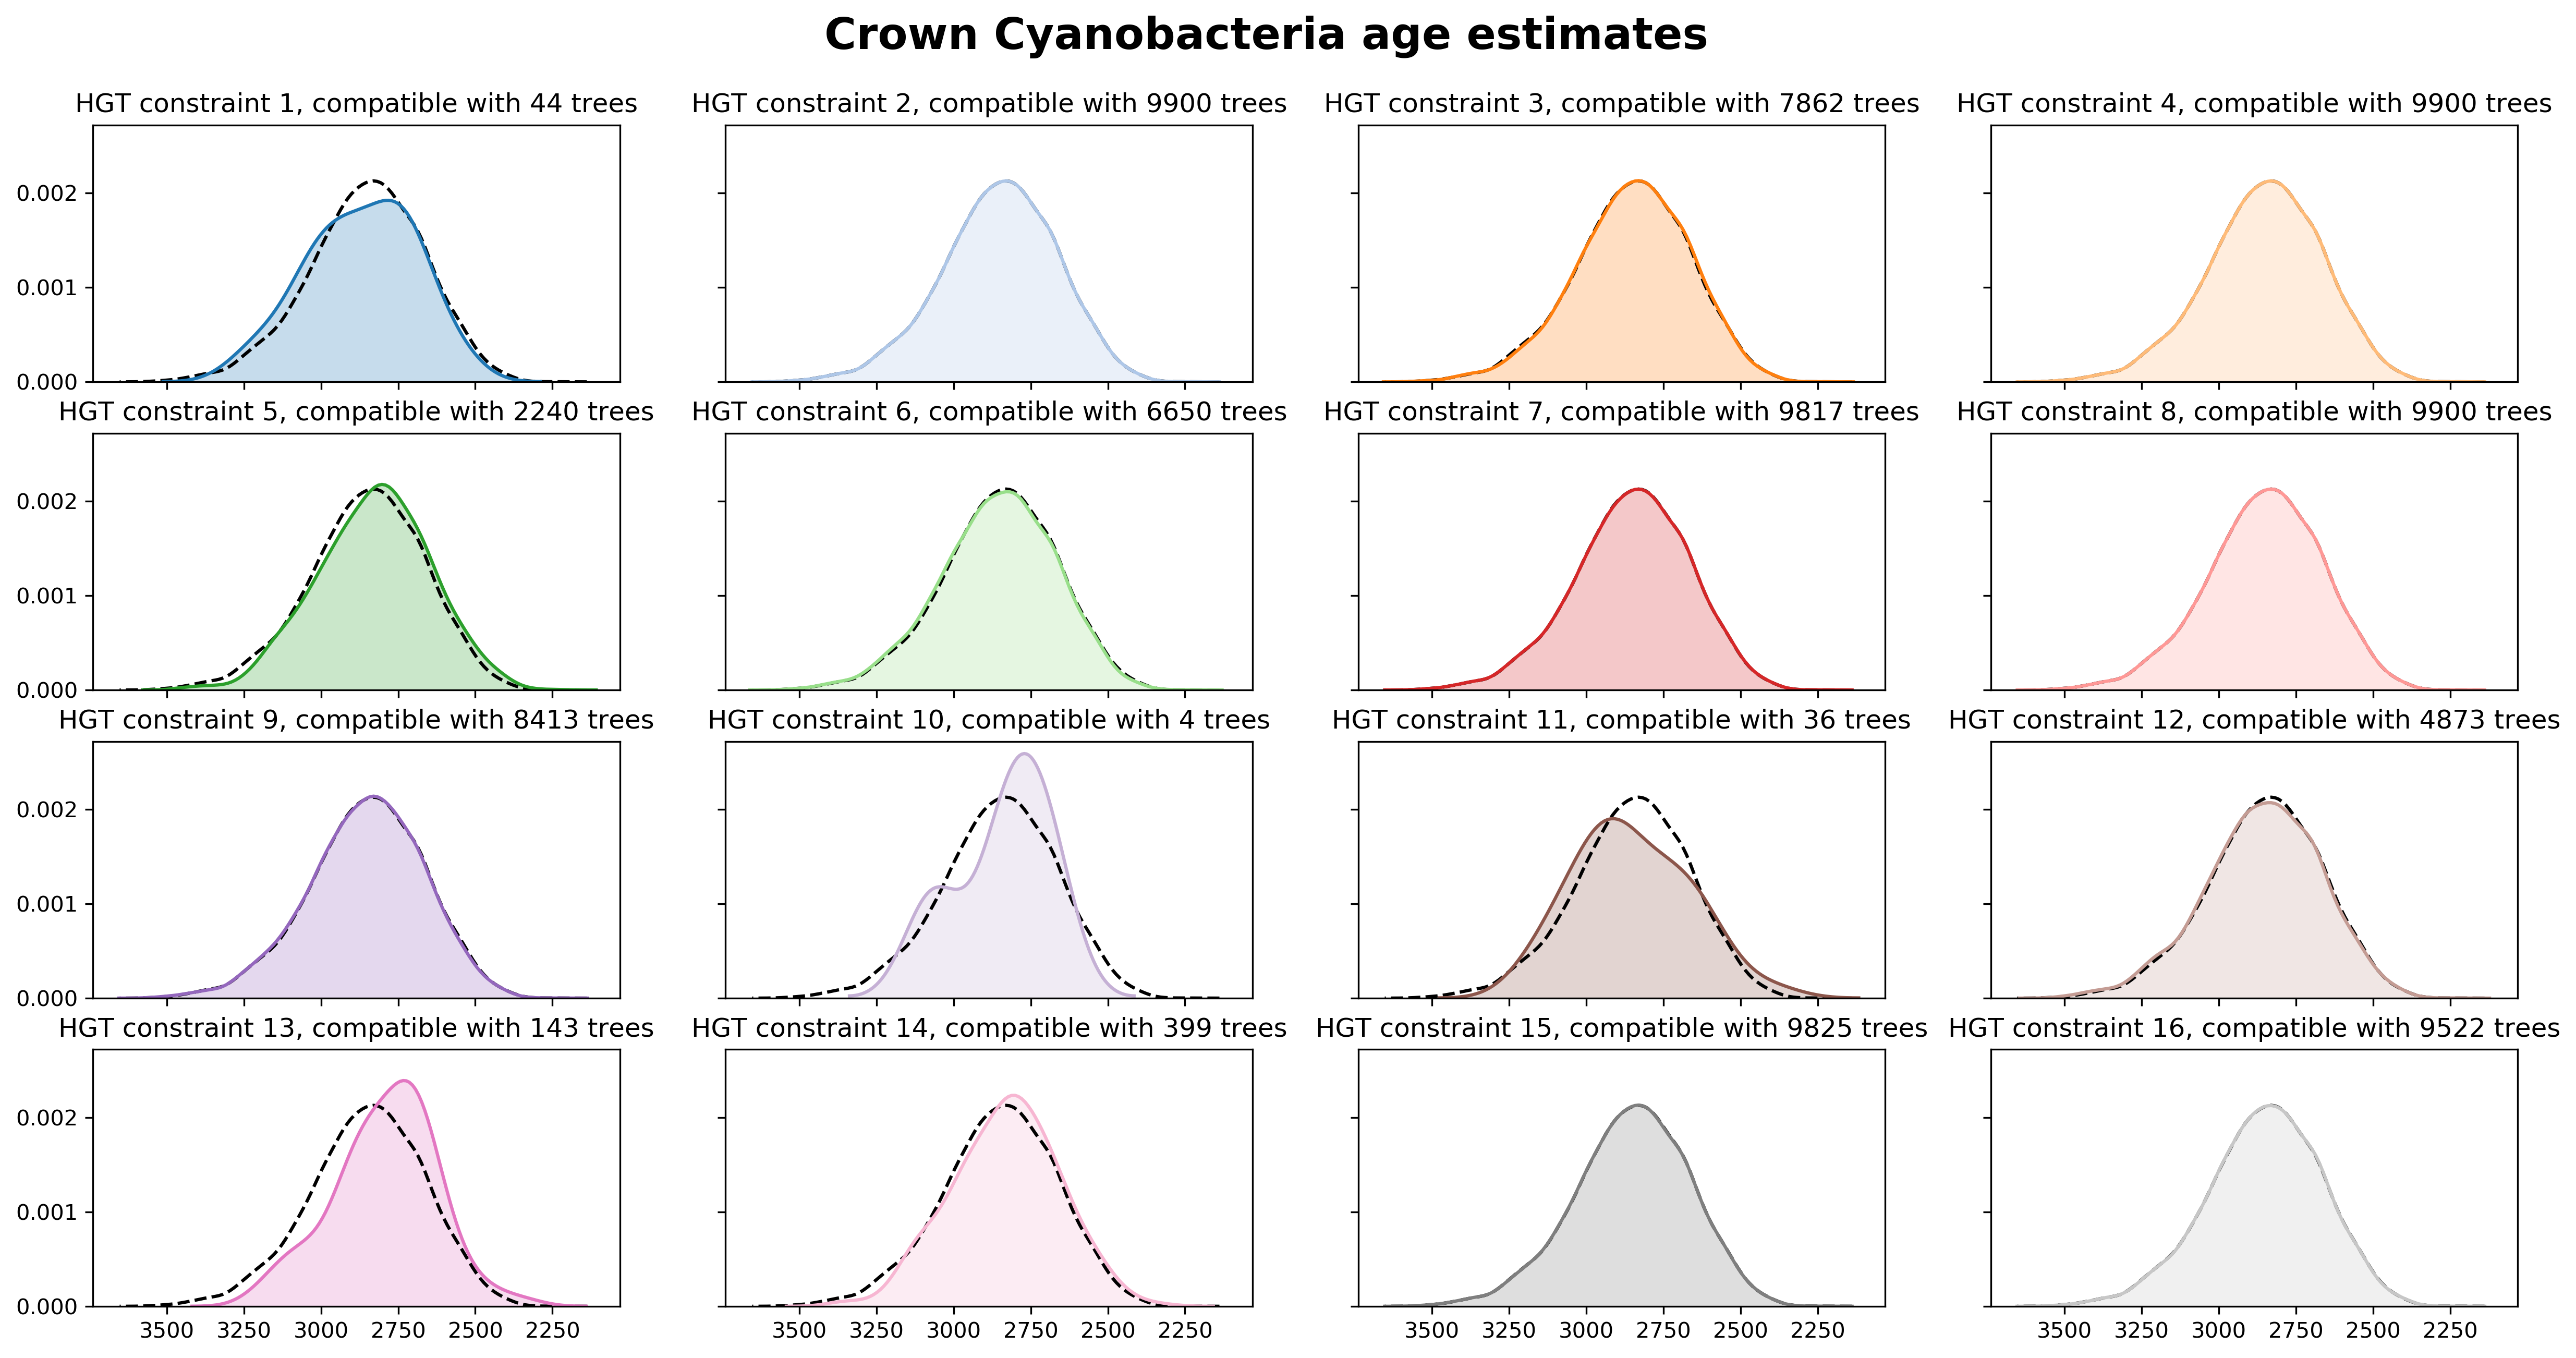

In [180]:
#cyanos     = tree.search_nodes(pb_name='177')[0].get_leaf_names()
#cyano_ages = np.array([get_node_age_from_descendants(tmp_tree, cyanos)
#                       for tmp_tree in posterior_trees])

fig, axs = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, dpi=300, figsize=(20,10))
count    = 1
colors = sns.color_palette("tab20", 16)
for ax, (constraint, compatibilities) in zip(itertools.chain.from_iterable(axs),
                                             highpass_constraints_compatibilities.iteritems()):
    sns.kdeplot(cyano_ages,
                ax=ax,
                shade=False,
               color = 'black',
               linestyle="--")

    sns.kdeplot(cyano_ages[compatibilities.tolist()],
                ax=ax,
                shade=True,
               color = colors[count-1])
    ax.set_title('HGT constraint %i, compatible with %i trees' % (count, compatibilities.sum()))
    count += 1
fig.suptitle('Crown Cyanobacteria age estimates', y=0.95, fontsize=20, fontweight='bold')
ax.invert_xaxis()

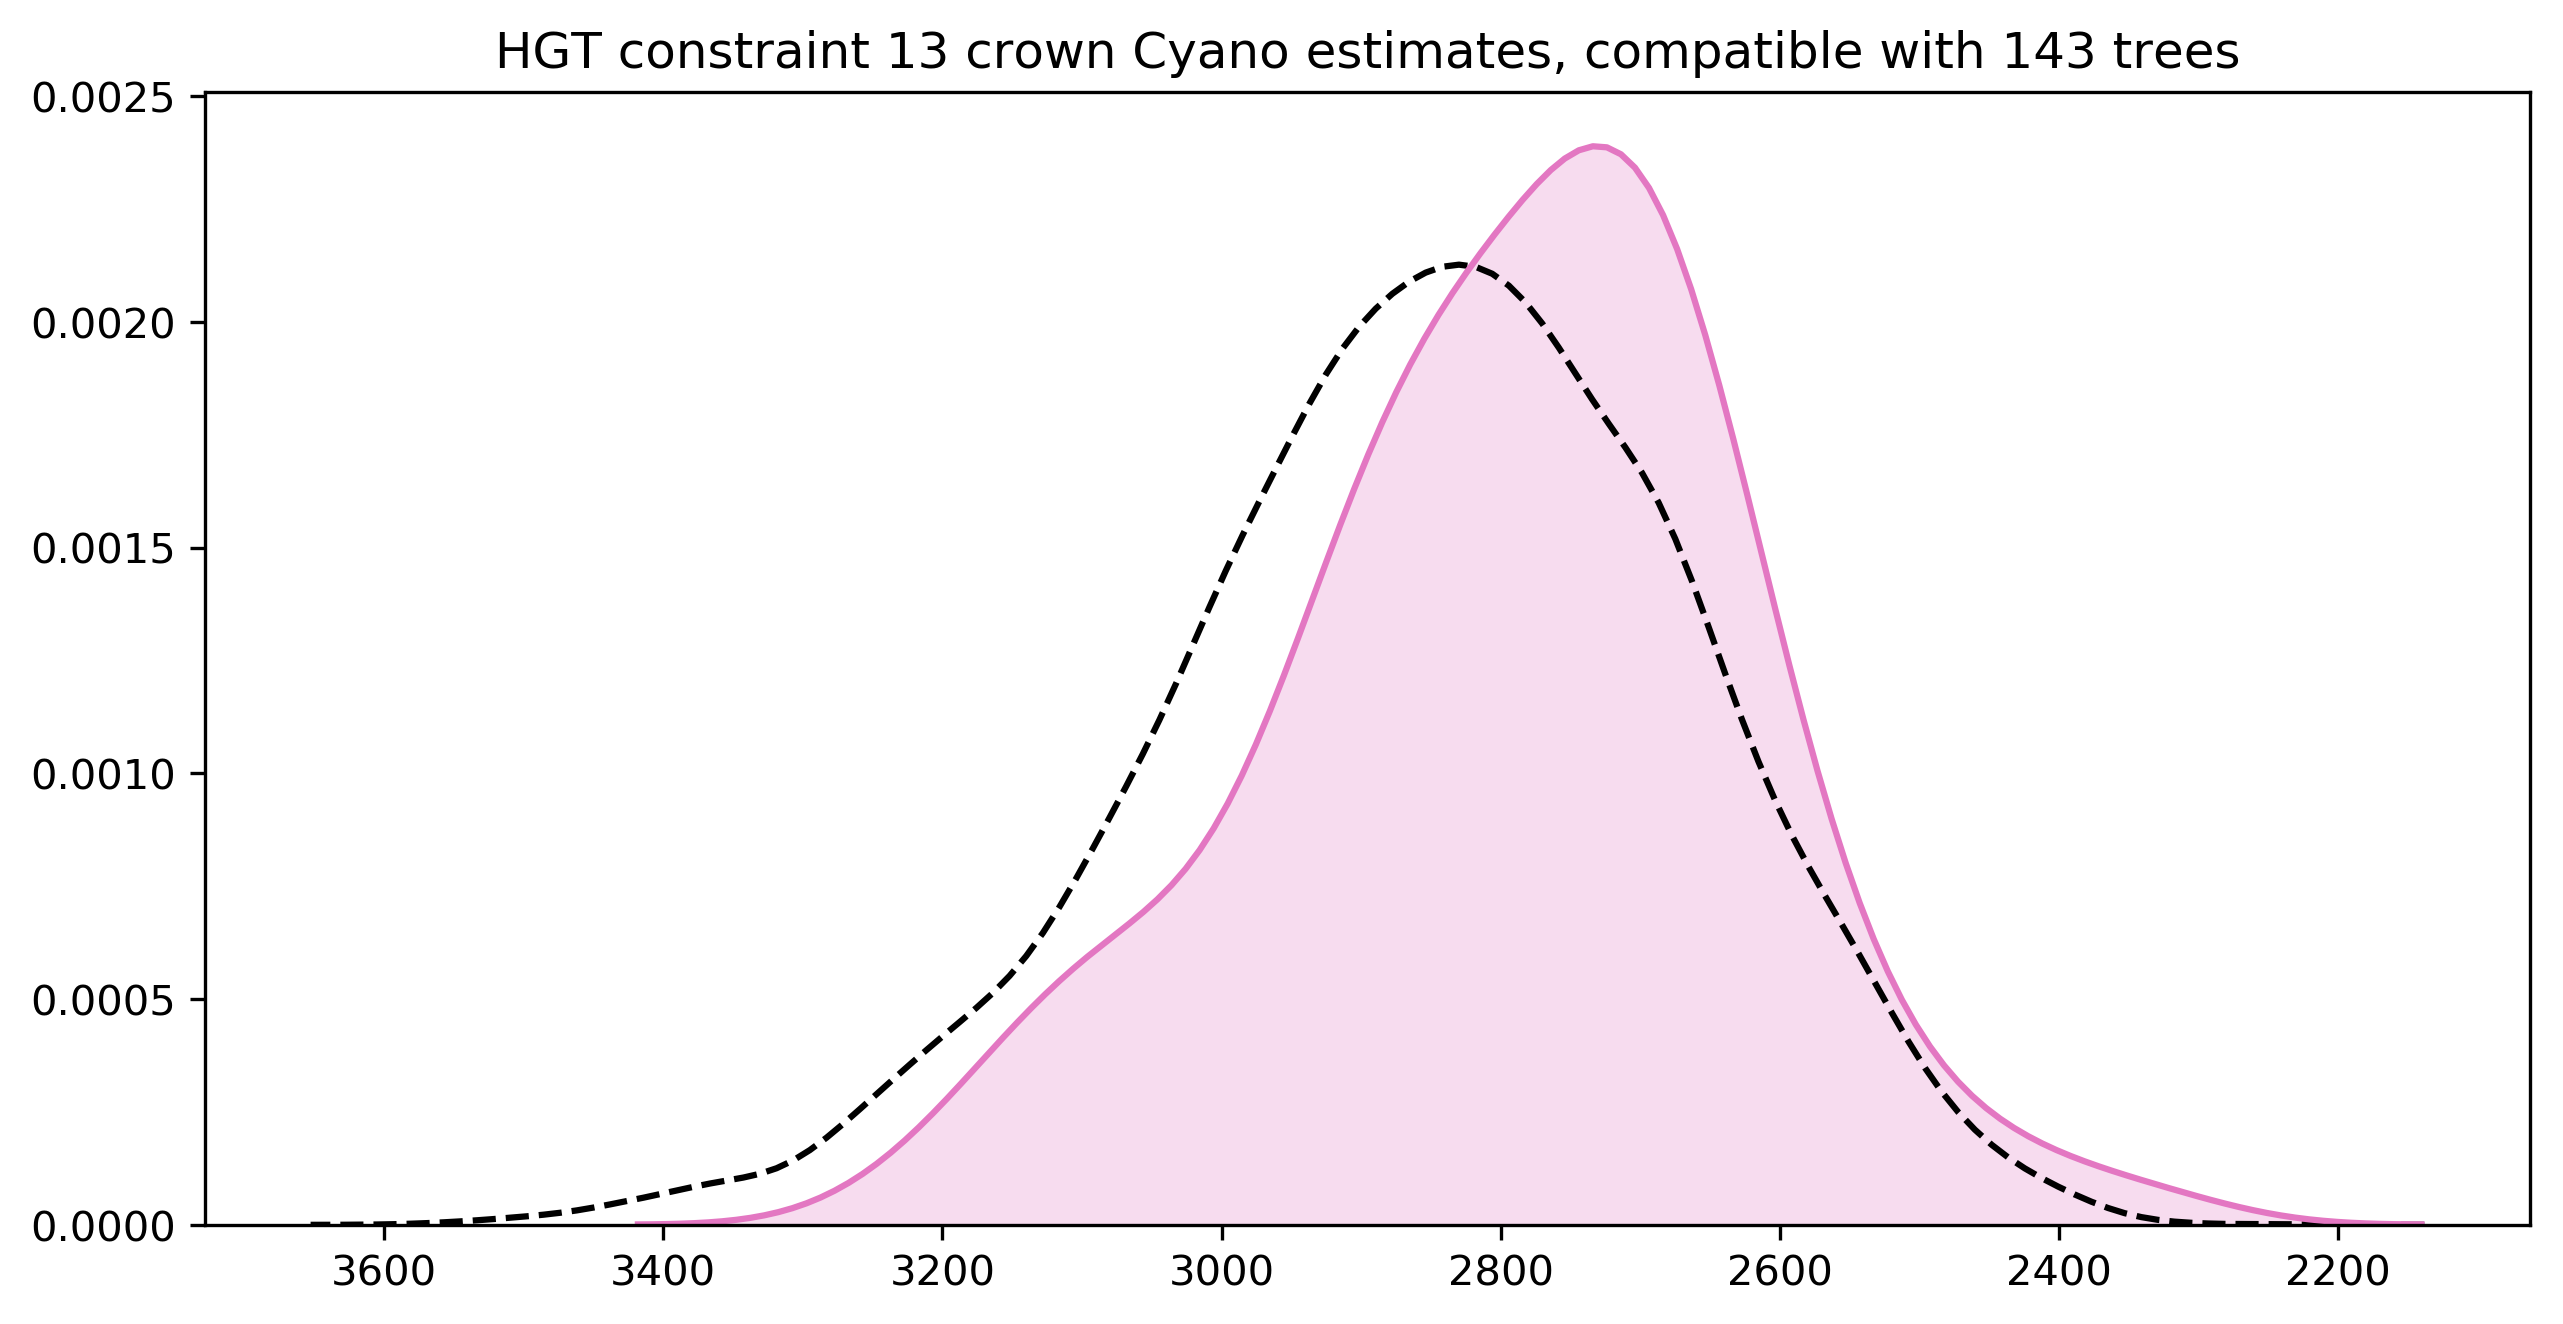

In [179]:
fig, ax = plt.subplots(dpi=300, figsize=(10,5))

constraint, compatibilities = list(highpass_constraints_compatibilities.iteritems())[12]
sns.kdeplot(cyano_ages,
            ax=ax,
            shade=False,
           color = 'black',
           linestyle="--")

sns.kdeplot(cyano_ages[compatibilities.tolist()],
            ax=ax,
            shade=True,
           color = colors[12])
ax.set_title('HGT constraint 13 crown Cyanobacteria estimates, compatible with %i trees' % (compatibilities.sum()))
ax.invert_xaxis()

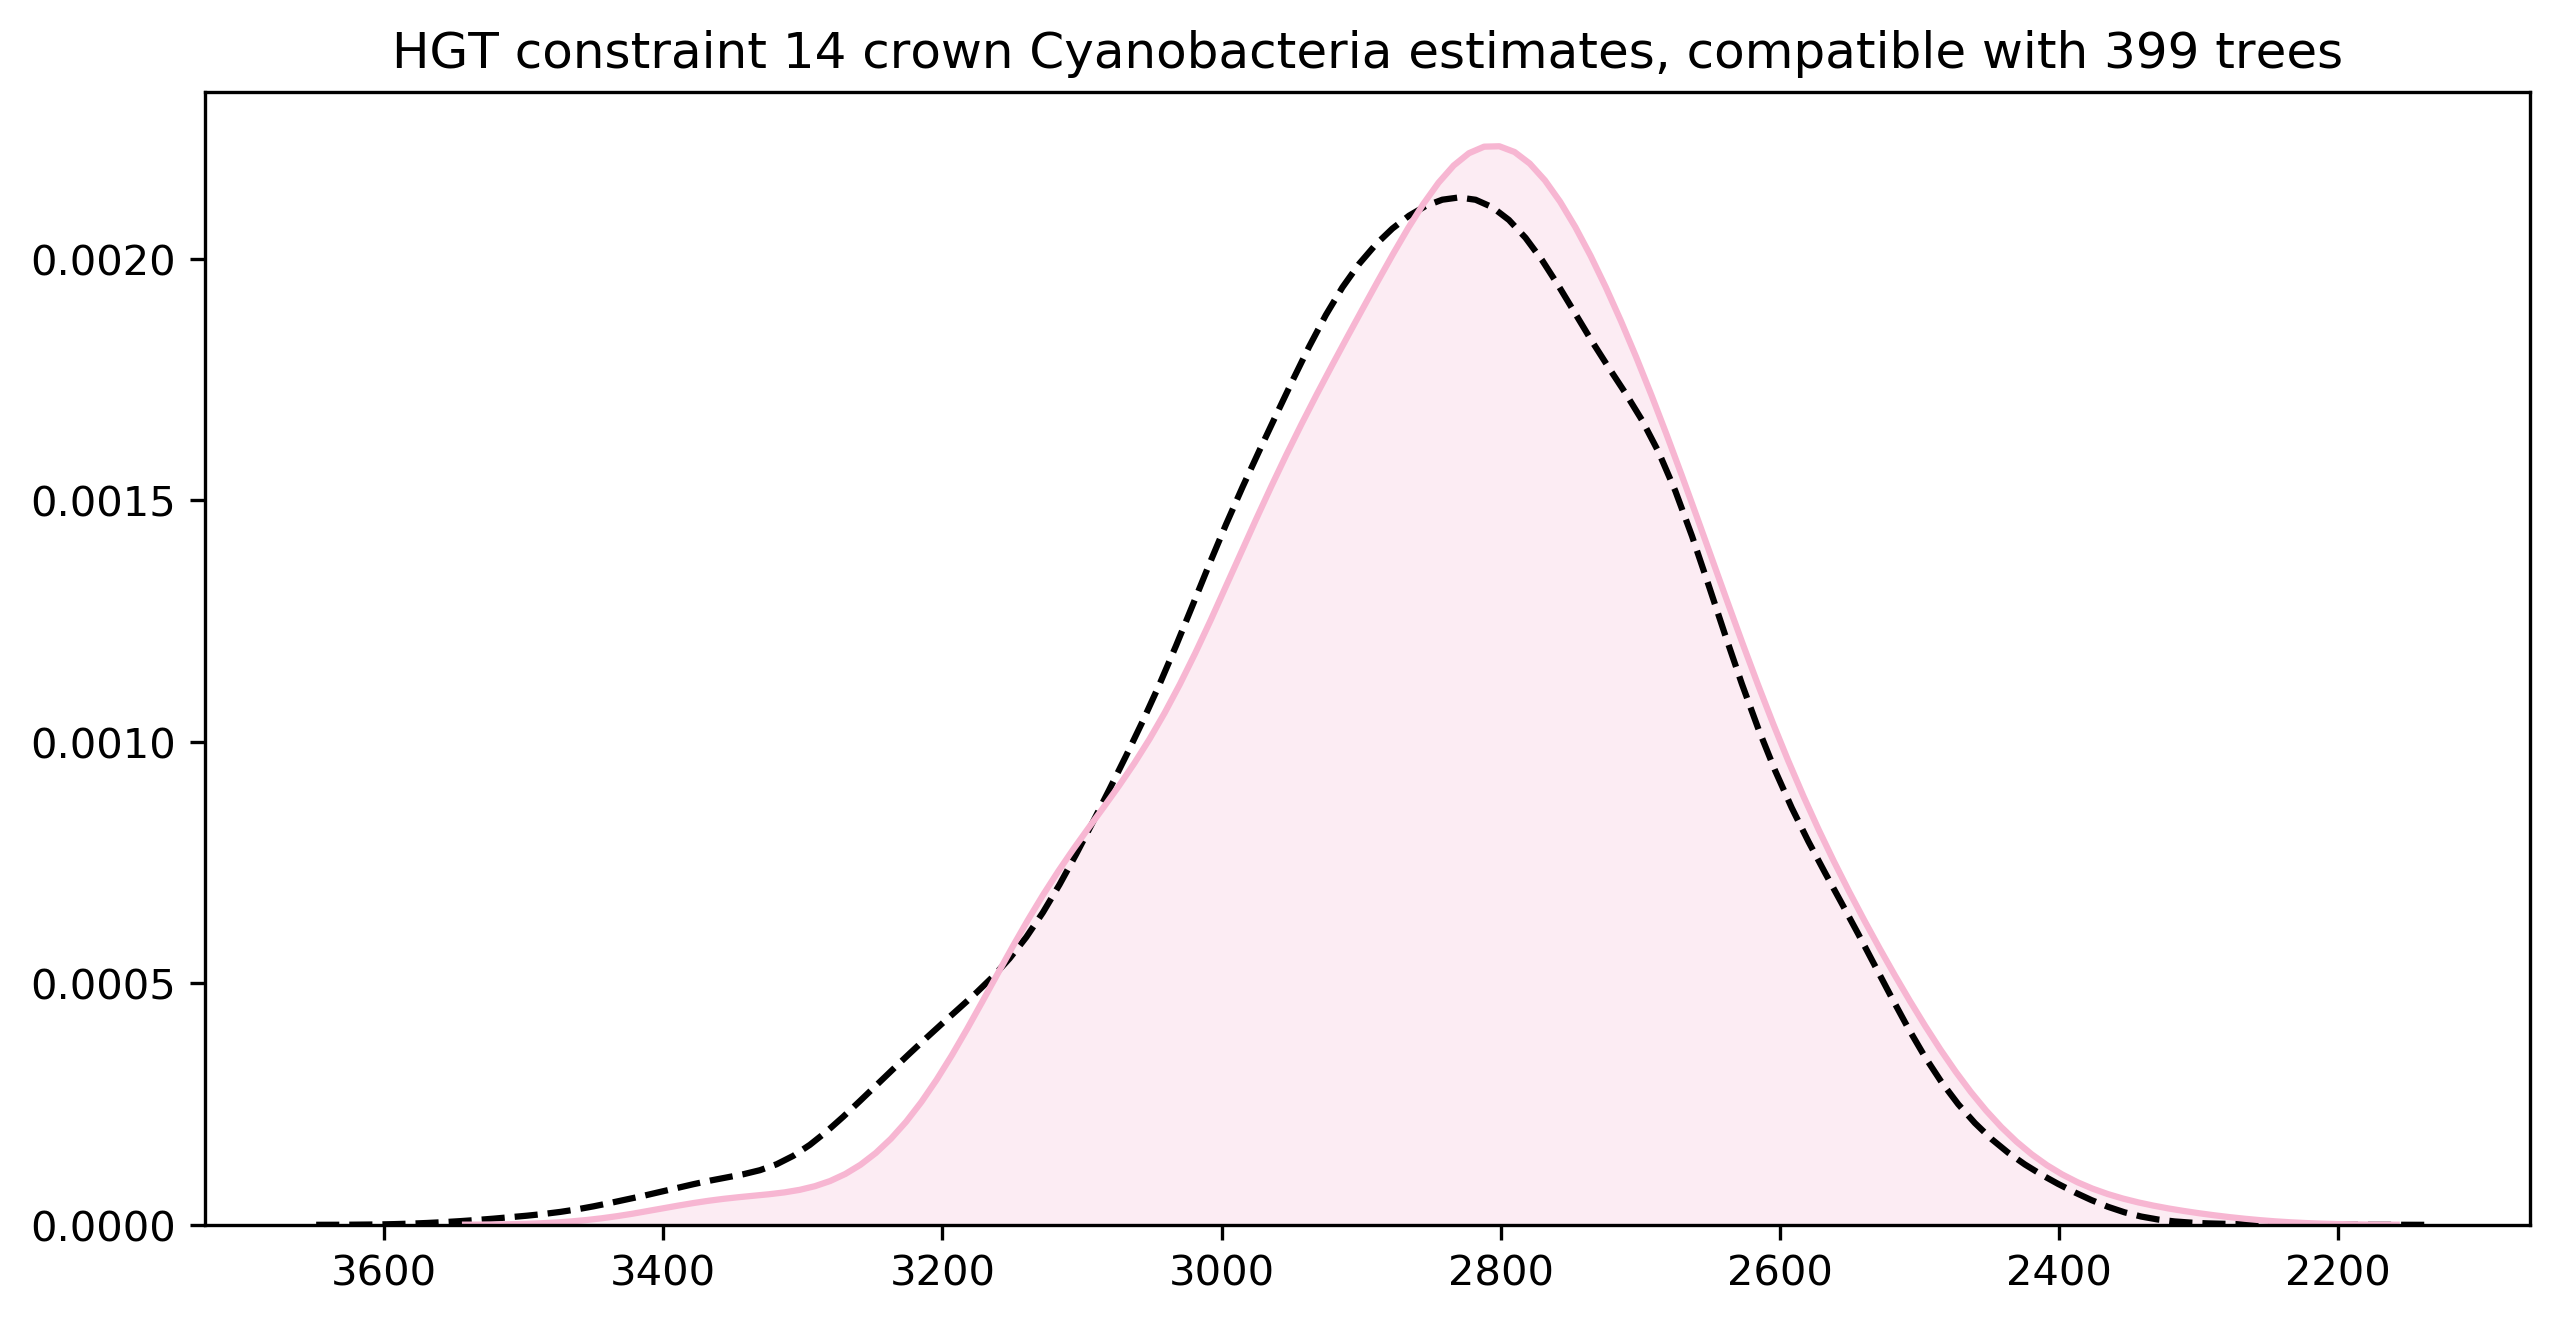

In [182]:
fig, ax = plt.subplots(dpi=300, figsize=(10,5))

constraint, compatibilities = list(highpass_constraints_compatibilities.iteritems())[13]
sns.kdeplot(cyano_ages,
            ax=ax,
            shade=False,
           color = 'black',
           linestyle="--")

sns.kdeplot(cyano_ages[compatibilities.tolist()],
            ax=ax,
            shade=True,
           color = colors[13])
ax.set_title('HGT constraint 14 crown Cyanobacteria estimates, compatible with %i trees' % (compatibilities.sum()))
ax.invert_xaxis()